# **Customer Satisfaction Prediction for Rail Services**

### An End-to-End Data Science Case Study to Support Customer Retention


---


## **Business Case**

----

A train company has collected operational data for each ticket (delays, distance, trip purpose, and customer profile details) together with post-trip service ratings. These ratings are requested through a follow-up email sent after the service, and customers are free to ignore it, so rating data is valuable but not always available.

The core business objective is to understand what drives the `Satisfied` outcome (`Y`/`N`) so the company can act before dissatisfied customers churn. A clear view of the main satisfaction drivers helps both marketing and operations teams prioritize the right actions.

From a business perspective, this analysis supports three outcomes:
- improve retention and repeat bookings by reducing the main causes of dissatisfaction;
- make promotions more efficient by targeting segments with higher dissatisfaction risk;
- prioritize service and operational investments (punctuality, onboard service, cleanliness, comfort, Wi-Fi, booking experience, ...) based on measurable impact.

In this project, we use exploratory analysis and machine learning classification models to predict satisfaction and identify the most influential variables. To stay deployable in real operations, results are interpreted with two complementary tracks: one when post-trip ratings are available and one when they are missing.

## **Initial Setup**

----


##### **Importing Libraries** and Theme Setting

This section imports the libraries used for data manipulation, visualization, preprocessing, model training, and model evaluation.


In [1]:
# Import all libraries used throughout this notebook.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
from scipy.stats import chi2_contingency
from IPython.display import display
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, confusion_matrix
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from matplotlib.patches import Patch

# Shared notebook plotting theme and palettes.
PLOT_BG = '#1a1d24'
PLOT_FG = '#e0e2e6'
BASE_PALETTE = ['#c88a42', '#c8a97e', '#4a6c8c', '#788a9c', '#e0e2e6']

RATING_PALETTE = {
    5: '#c88a42',
    4: '#c8a97e',
    3: '#4a6c8c',
    2: '#788a9c',
    1: '#e0e2e6'
}

MODEL_PALETTE = {
    'Random Forest': '#c88a42',
    'Decision Tree': '#c8a97e',
    'K Nearest Neighbors': '#4a6c8c',
    'Logistic Regression': '#788a9c'
}
MODEL_SHORT_PALETTE = {'RF': '#c88a42', 'DT': '#c8a97e', 'KNN': '#4a6c8c', 'LR': '#788a9c'}

SATISFIED_PALETTE = {'Y': '#c88a42', 'N': '#4a6c8c'}
STRENGTH_PALETTE = {'Strong': '#c88a42', 'Moderate': '#4a6c8c', 'Weak': '#e0e2e6'}
CORRELATION_SCALE = ['#c88a42', '#c8a97e', '#4a6c8c', '#788a9c', '#e0e2e6']

PLOT_THEME_RC = {
    'font.family': 'DejaVu Sans',
    'figure.facecolor': PLOT_BG,
    'axes.facecolor': PLOT_BG,
    'savefig.facecolor': PLOT_BG,
    'axes.edgecolor': PLOT_FG,
    'axes.labelcolor': PLOT_FG,
    'axes.titlecolor': PLOT_FG,
    'xtick.color': PLOT_FG,
    'ytick.color': PLOT_FG,
    'text.color': PLOT_FG,
    'grid.color': BASE_PALETTE[3],
    'grid.alpha': 0.25,
    'legend.facecolor': PLOT_BG,
    'legend.edgecolor': BASE_PALETTE[3],
    'legend.labelcolor': PLOT_FG
}

plt.rcParams.update(PLOT_THEME_RC)
sns.set_theme(style='whitegrid', rc=PLOT_THEME_RC)

def style_axes(ax):
    ax.set_facecolor(PLOT_BG)
    for spine in ax.spines.values():
        spine.set_color(PLOT_FG)
    ax.tick_params(colors=PLOT_FG)
    ax.xaxis.label.set_color(PLOT_FG)
    ax.yaxis.label.set_color(PLOT_FG)
    ax.title.set_color(PLOT_FG)
    return ax

def style_legend(legend):
    if legend is None:
        return
    frame = legend.get_frame()
    frame.set_facecolor(PLOT_BG)
    frame.set_edgecolor(BASE_PALETTE[3])
    for text in legend.get_texts():
        text.set_color(PLOT_FG)
    title = legend.get_title()
    if title is not None:
        title.set_color(PLOT_FG)

def plot_roc_custom(fpr, tpr, model_label):
    model_color = MODEL_PALETTE.get(model_label, BASE_PALETTE[0])
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.plot([0, 1], [0, 1], linestyle='--', color=BASE_PALETTE[-1], linewidth=1.2, label='Baseline')
    ax.plot(fpr, tpr, marker='.', color=model_color, linewidth=2, label=model_label)
    ax.set_title(f'ROC Curve - {model_label}')
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    style_axes(ax)
    legend = ax.legend(loc='lower right')
    style_legend(legend)
    plt.tight_layout()
    plt.show()


##### **Importing the Dataset**

This step loads `trains.csv` into a pandas DataFrame and performs an initial inspection of the records.


In [2]:
# Load the dataset and inspect the first rows.
trains_df = pd.read_csv('trains.csv')

trains_df.head()


,Legroom Service Rating,Onboard General Rating,Food'n'Drink Rating,Age,Departure Arrival Time Rating,Onboard WiFi Rating,Ticket ID,Checkin Rating,Track Location Rating,Baggage Handling Rating,...,Online Booking Rating,Satisfied,Onboard Entertainment Rating,Date and Time,Distance,Seat Comfort Rating,Work or Leisure,Departure Delay in Minutes,Onboard Service Rating,Cleanliness Rating
0,3,5,5,13,4,3,4718594,4,1,4,...,3,N,5,2016-02-19 10:53,460,5,leisure,25,4,5
1,5,4,1,25,2,3,1048580,1,3,3,...,3,N,1,2016-02-26 15:39,235,1,work,1,1,1
2,3,4,5,26,2,2,3670024,4,2,4,...,2,Y,5,2016-02-26 07:26,1142,5,work,0,4,5
3,5,4,2,25,5,2,3145737,1,5,3,...,5,N,2,2016-02-27 08:32,562,2,work,11,2,2
4,4,3,4,61,3,3,5767177,3,3,4,...,3,Y,3,2016-02-27 14:37,214,5,work,0,3,3


##### **Dataset Features**

The dataset combines customer profile information, trip context, operational variables, and post-trip service ratings.

- **Target variable**: `Satisfied` (`Y` = satisfied, `N` = not satisfied).
- **Customer profile**: `Age`, `Gender`, `Loyalty`.
- **Trip context**: `Work or Leisure`, `Ticket Class`, `Distance`, `Date and Time`.
- **Operational variables**: `Departure Delay in Minutes`, `Arrival Delay in Minutes`.
- **Service ratings (1 to 5)**: `Onboard General Rating`, `Baggage Handling Rating`, `Cleanliness Rating`, `Food'n'Drink Rating`, `Online Booking Rating`, `Onboard Service Rating`, `Legroom Service Rating`, `Checkin Rating`, `Onboard Entertainment Rating`, `Boarding Rating`, `Onboard WiFi Rating`, `Seat Comfort Rating`, `Track Location Rating`, and `Departure Arrival Time Rating`.
- **Identifier**: `Ticket ID` (record identifier, excluded from model training).


---


## **Exploratory Data Analysis (EDA)**

---


##### **Dataset Overview**

This section summarizes dataset size, data types, feature distributions, and overall data quality before modeling.

In [3]:
# Perform basic dataset exploration.
print("Information of the dataset:"), (trains_df.info())
print("\nShape of the dataset:", trains_df.shape)


Information of the dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119567 entries, 0 to 119566
Data columns (total 25 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   Legroom Service Rating         119567 non-null  int64  
 1   Onboard General Rating         119567 non-null  int64  
 2   Food'n'Drink Rating            119567 non-null  int64  
 3   Age                            119567 non-null  int64  
 4   Departure Arrival Time Rating  119567 non-null  int64  
 5   Onboard WiFi Rating            119567 non-null  int64  
 6   Ticket ID                      119567 non-null  int64  
 7   Checkin Rating                 119567 non-null  int64  
 8   Track Location Rating          119567 non-null  int64  
 9   Baggage Handling Rating        119567 non-null  int64  
 10  Arrival Delay in Minutes       119204 non-null  float64
 11  Ticket Class                   119567 non-null  object 
 12  Lo

In [4]:
trains_df.describe()

,Legroom Service Rating,Onboard General Rating,Food'n'Drink Rating,Age,Departure Arrival Time Rating,Onboard WiFi Rating,Ticket ID,Checkin Rating,Track Location Rating,Baggage Handling Rating,Arrival Delay in Minutes,Boarding Rating,Online Booking Rating,Onboard Entertainment Rating,Distance,Seat Comfort Rating,Departure Delay in Minutes,Onboard Service Rating,Cleanliness Rating
count,119567.000000,119567.000000,119567.000000,119567.000000,119567.000000,119567.000000,1.195670e+05,119567.000000,119567.000000,119567.000000,119204.000000,119567.000000,119567.000000,119567.000000,119567.000000,119567.000000,119567.000000,119567.000000,119567.000000
mean,3.380381,3.646399,3.213788,39.858021,3.206838,2.817943,5.495493e+06,3.294747,2.986961,3.637333,15.284361,3.330551,2.879172,3.380423,1223.933627,3.456221,14.909532,3.386185,3.294053
std,1.295580,1.165786,1.324438,15.030382,1.386886,1.253511,2.596130e+06,1.266249,1.282049,1.167878,38.687386,1.263108,1.298754,1.327173,999.732592,1.311765,38.310203,1.285412,1.310393
min,1.000000,1.000000,1.000000,7.000000,1.000000,1.000000,1.000025e+06,1.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,31.000000,1.000000,0.000000,1.000000,1.000000
25%,2.000000,3.000000,2.000000,28.000000,2.000000,2.000000,3.242118e+06,2.000000,2.000000,3.000000,0.000000,2.000000,2.000000,2.000000,441.000000,2.000000,0.000000,2.000000,2.000000
50%,4.000000,4.000000,3.000000,40.000000,3.000000,3.000000,5.498759e+06,3.000000,3.000000,4.000000,0.000000,4.000000,3.000000,4.000000,868.000000,4.000000,0.000000,4.000000,3.000000
75%,4.000000,5.000000,4.000000,51.000000,4.000000,4.000000,7.739176e+06,4.000000,4.000000,5.000000,13.000000,4.000000,4.000000,4.000000,1775.000000,5.000000,13.000000,4.000000,4.000000
max,5.000000,5.000000,5.000000,85.000000,5.000000,5.000000,9.999975e+06,5.000000,5.000000,5.000000,1584.000000,5.000000,5.000000,5.000000,4983.000000,5.000000,1592.000000,5.000000,5.000000


##### **Distribution Analysis**

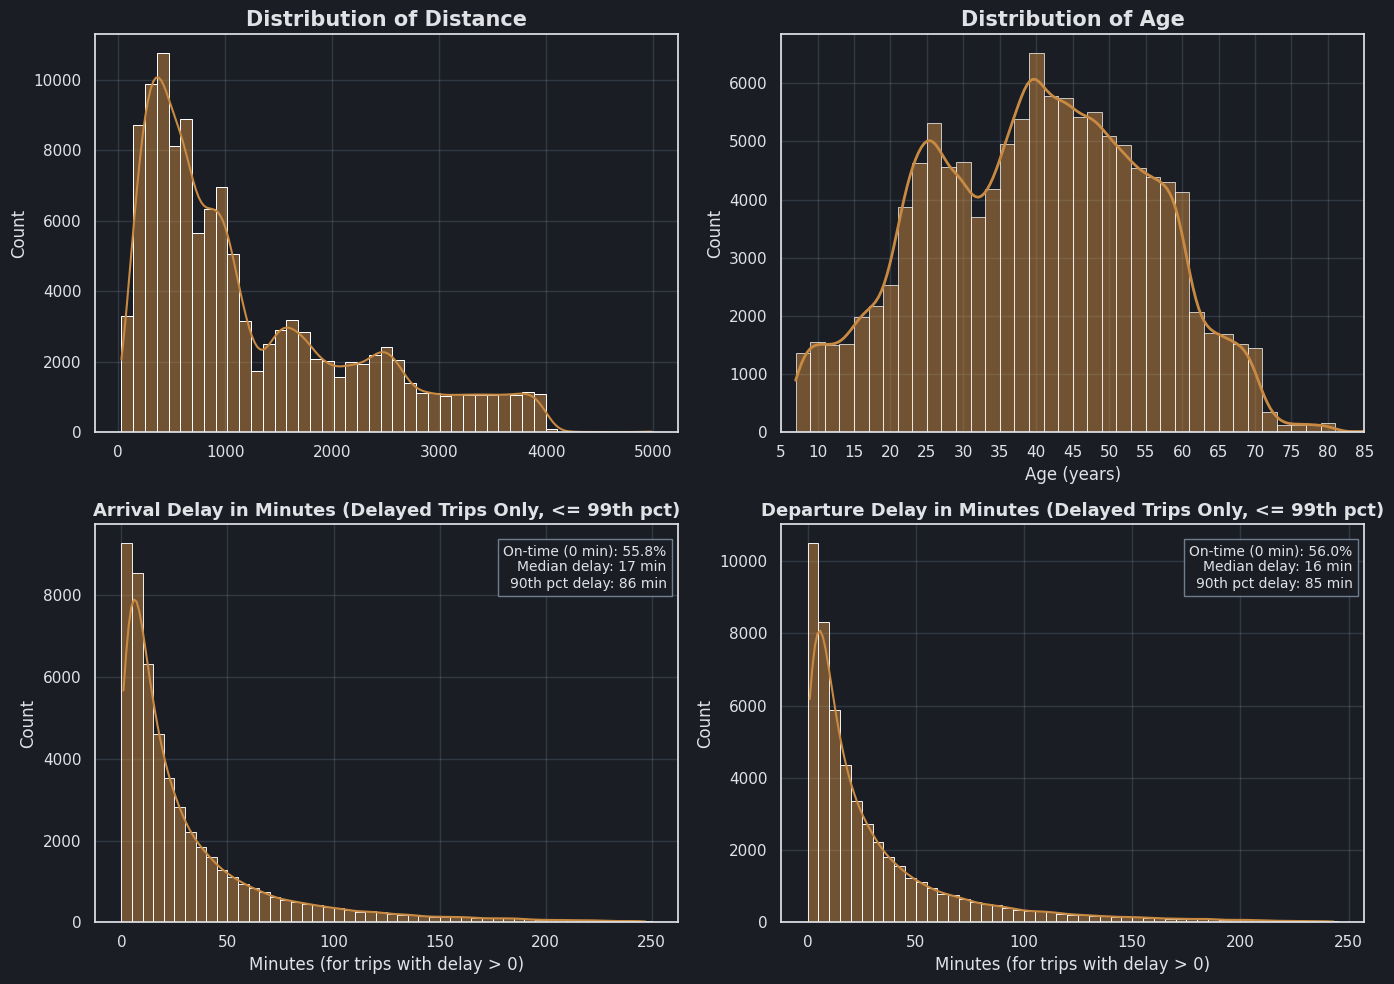

In [5]:
primary_color = BASE_PALETTE[0]
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))

# 1) Distance distribution.
distance = trains_df['Distance'].dropna()
sns.histplot(distance, bins=45, kde=True, color=primary_color, ax=axes[0, 0])
axes[0, 0].set_title('Distribution of Distance', fontsize=15, fontweight='bold')
axes[0, 0].set_xlabel('')

# 2) Age distribution.
age = trains_df['Age'].dropna()
age_bins = np.arange(5, 88, 2)  # 2-year-width bins
sns.histplot(
    age,
    bins=age_bins,
    kde=True,
    color=primary_color,
    edgecolor='white',
    linewidth=0.5,
    line_kws={'linewidth': 2, 'color': BASE_PALETTE[1]},
    ax=axes[0, 1]
)
axes[0, 1].set_title('Distribution of Age', fontsize=15, fontweight='bold')
axes[0, 1].set_xlim(5, 85)
axes[0, 1].set_xticks(np.arange(5, 86, 5))
axes[0, 1].set_xlabel('Age (years)')
axes[0, 1].set_ylabel('Count')

# 3-4) Delay distributions: cap at the 99th percentile.
def plot_delay(ax, col_name):
    delay = trains_df[col_name].dropna()
    on_time_share = (delay == 0).mean() * 100

    delayed = delay[delay > 0]
    if delayed.empty:
        ax.text(0.5, 0.5, 'No delayed trips (>0 min)', transform=ax.transAxes, ha='center', va='center')
        ax.set_title(f'{col_name} (Delayed Trips)', fontsize=15, fontweight='bold')
        return

    p99_delayed = delayed.quantile(0.99)
    delayed_trim = delayed[delayed <= p99_delayed]
    median_delayed = delayed.median()
    p90_delayed = delayed.quantile(0.90)

    bins = np.arange(0, p99_delayed + 6, 5)
    if len(bins) < 3:
        bins = 20

    sns.histplot(delayed_trim, bins=bins, kde=True, color=primary_color, ax=ax)
    ax.set_title(f'{col_name} (Delayed Trips Only, <= 99th pct)', fontsize=13, fontweight='bold')
    ax.set_xlabel('Minutes (for trips with delay > 0)')
    ax.set_ylabel('Count')

    ax.text(
        0.98, 0.95,
        f'On-time (0 min): {on_time_share:.1f}%\n'
        f'Median delay: {median_delayed:.0f} min\n'
        f'90th pct delay: {p90_delayed:.0f} min',
        transform=ax.transAxes,
        ha='right', va='top',
        fontsize=10,
        bbox=dict(facecolor=PLOT_BG, alpha=0.9, edgecolor=BASE_PALETTE[3])
    )

plot_delay(axes[1, 0], 'Arrival Delay in Minutes')
plot_delay(axes[1, 1], 'Departure Delay in Minutes')

for ax in axes.flatten():
    style_axes(ax)

# Apply a tight layout to prevent subplot overlap.
plt.tight_layout()
plt.show()


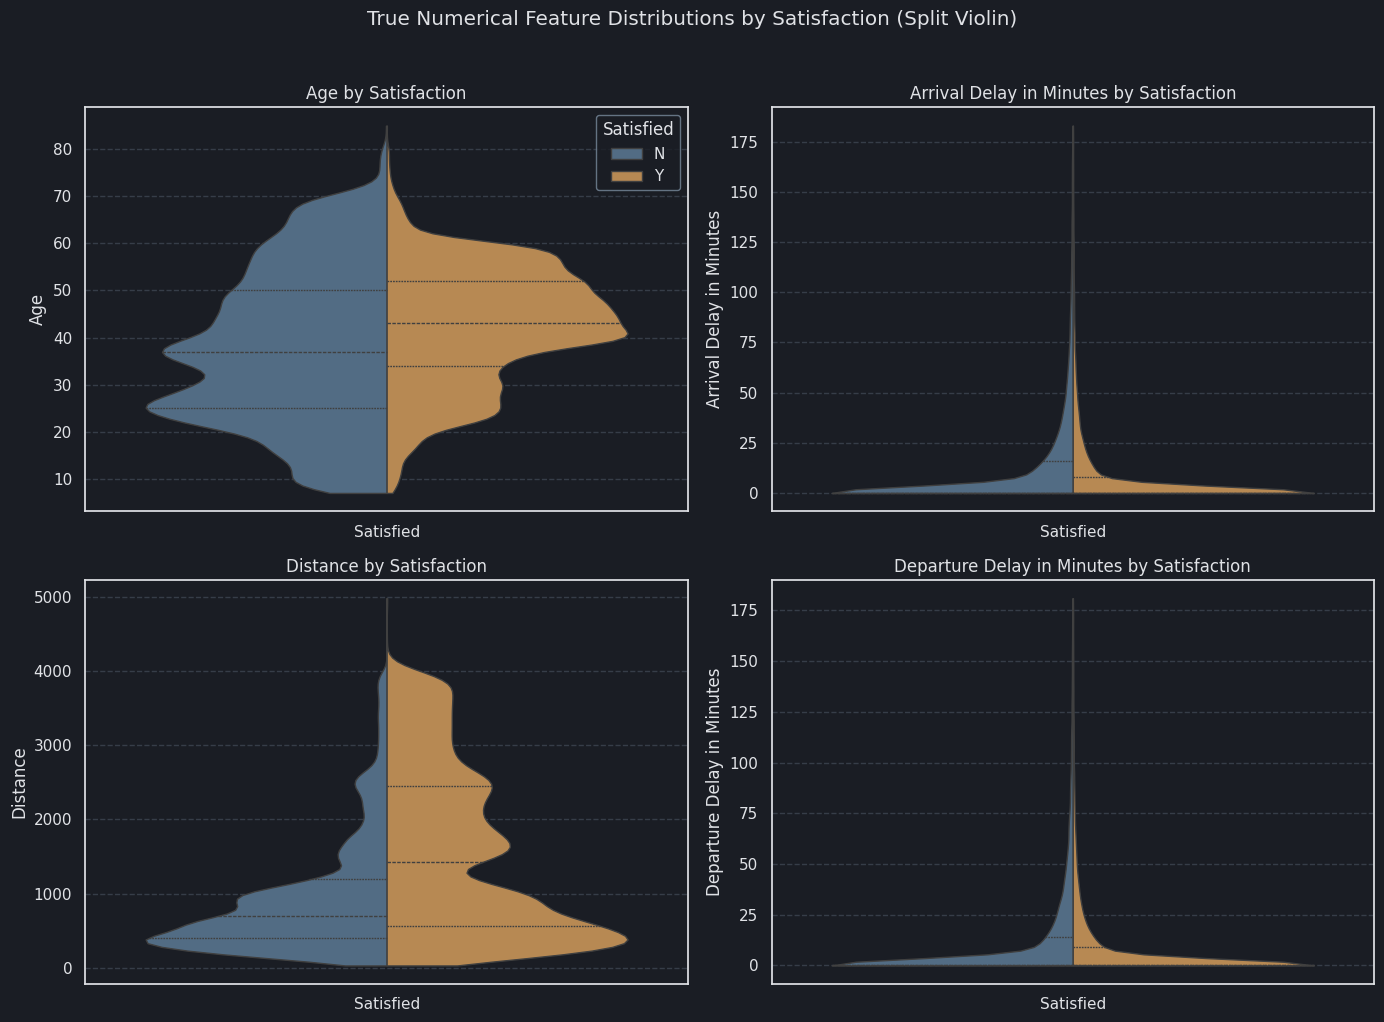

In [6]:
# Plot split violin distributions of numerical features by satisfaction class (N/Y).
source_df = trains_df.copy()
feature_numeric_cols = [
    col for col in source_df.select_dtypes(include=[np.number]).columns
    if ('Rating' not in col) and (col != 'Ticket ID') and (not col.startswith('Travel'))
]
target_label_map = {0: 'N', 1: 'Y', 'N': 'N', 'Y': 'Y'}
violin_palette = {'N': SATISFIED_PALETTE['N'], 'Y': SATISFIED_PALETTE['Y']}
plot_base = source_df[feature_numeric_cols + ['Satisfied']].copy()
plot_base['Satisfied_Label'] = plot_base['Satisfied'].map(target_label_map)
plot_base = plot_base.dropna(subset=['Satisfied_Label'])
n_features = len(feature_numeric_cols)
n_cols = 2
n_rows = int(np.ceil(n_features / n_cols))
fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 5 * n_rows))
axes = np.atleast_1d(axes).flatten()
for i, col in enumerate(feature_numeric_cols):
    ax = axes[i]
    violin_df = plot_base[[col, 'Satisfied_Label']].dropna().copy()
    # Remove the extreme upper tail for delay features.
    if 'Delay' in col:
        upper_cap = violin_df[col].quantile(0.99)
        violin_df = violin_df[violin_df[col] <= upper_cap]
    violin_df['Feature'] = 'Satisfied'
    sns.violinplot(
        data=violin_df,
        x='Feature',
        y=col,
        hue='Satisfied_Label',
        hue_order=['N', 'Y'],
        split=True,
        inner='quartile',
        cut=0,
        linewidth=1,
        palette=violin_palette,
        ax=ax
    )
    ax.set_title(f'{col} by Satisfaction')
    ax.set_xlabel('')
    ax.set_ylabel(col)
    ax.grid(axis='y', linestyle='--', alpha=0.3, color=BASE_PALETTE[3])
    style_axes(ax)
    legend = ax.get_legend()
    if i > 0 and legend is not None:
        legend.remove()
for j in range(n_features, len(axes)):
    axes[j].axis('off')
handles, labels = axes[0].get_legend_handles_labels()
if handles:
    legend = axes[0].legend(handles, labels, title='Satisfied', loc='upper right')
    style_legend(legend)
plt.suptitle('True Numerical Feature Distributions by Satisfaction (Split Violin)', y=1.02, color=PLOT_FG)
plt.tight_layout()
plt.show()


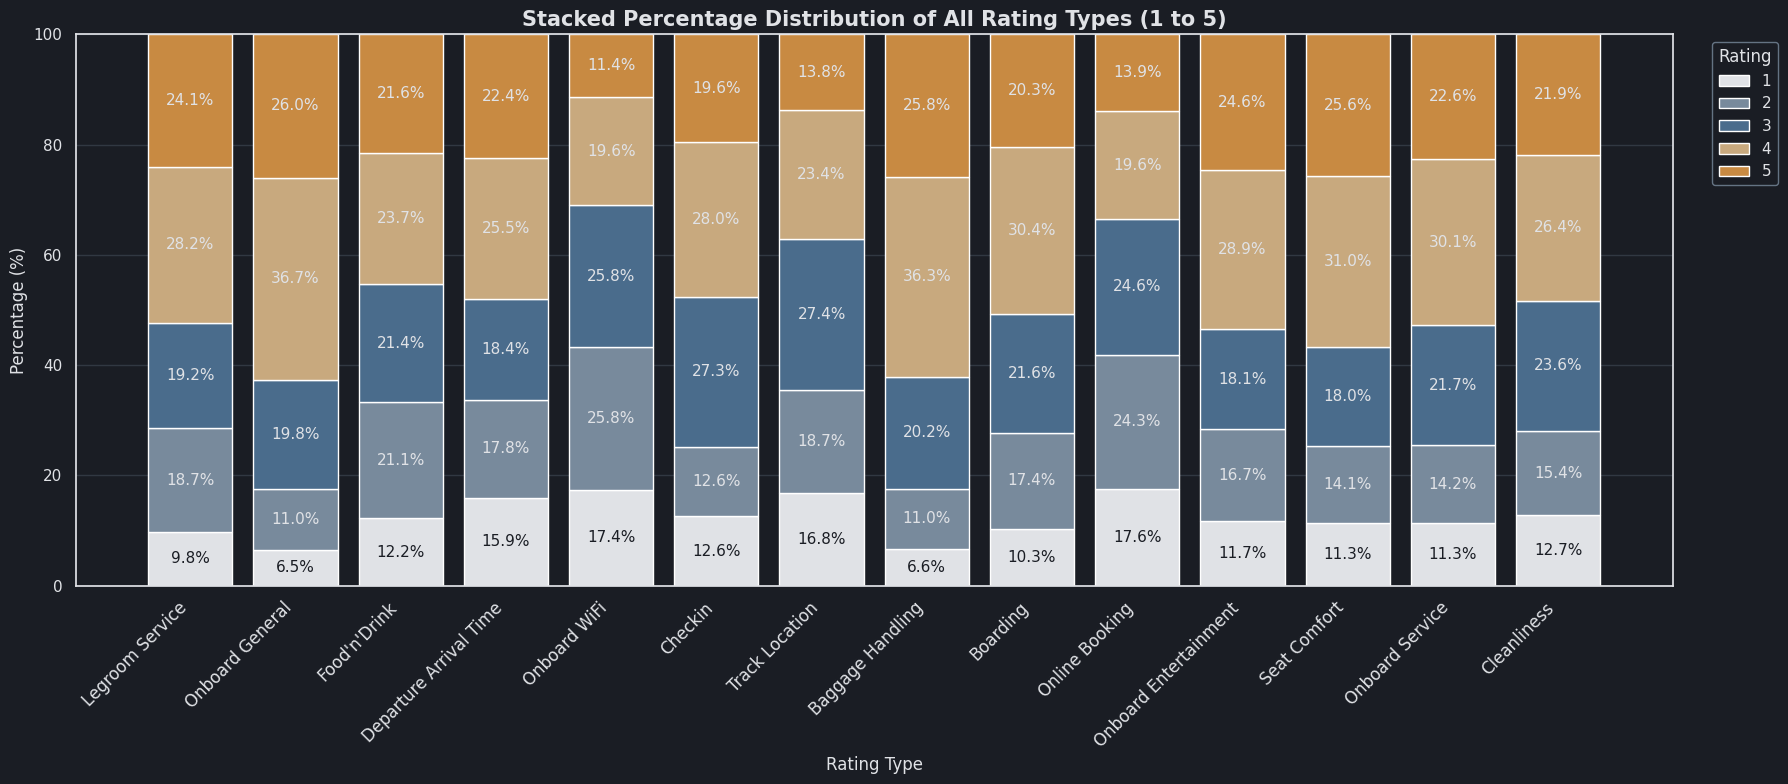

In [7]:
# Plot stacked percentage bars for all rating features (scores 1-5).
rating_columns = [col for col in trains_df.columns if col.endswith('Rating')]
rating_order = [1, 2, 3, 4, 5]
rating_colors = {rating: RATING_PALETTE[rating] for rating in rating_order}

rating_counts = trains_df[rating_columns].apply(
    lambda col: col.value_counts().reindex(rating_order, fill_value=0)
).T
rating_percentages = rating_counts.div(rating_counts.sum(axis=1), axis=0) * 100

fig, ax = plt.subplots(figsize=(18, 8))
x_labels = [col.replace(' Rating', '') for col in rating_percentages.index]
bottom = [0] * len(x_labels)

for rating in rating_order:
    values = rating_percentages[rating].tolist()
    bars = ax.bar(
        x_labels,
        values,
        bottom=bottom,
        color=rating_colors[rating],
        label=f'{rating}'
    )

    label_color = PLOT_BG if rating == 1 else PLOT_FG
    labels = [f'{v:.1f}%' if v > 0 else '' for v in values]
    ax.bar_label(bars, labels=labels, label_type='center', color=label_color, fontsize=11)

    bottom = [b + v for b, v in zip(bottom, values)]

ax.set_title('Stacked Percentage Distribution of All Rating Types (1 to 5)', fontsize=15, fontweight='bold')
ax.set_xlabel('Rating Type')
ax.set_ylabel('Percentage (%)')
ax.set_ylim(0, 100)
plt.xticks(rotation=45, ha='right', fontsize=12)
legend = ax.legend(title='Rating', bbox_to_anchor=(1.02, 1), loc='upper left')
style_legend(legend)
style_axes(ax)
plt.tight_layout()
plt.show()


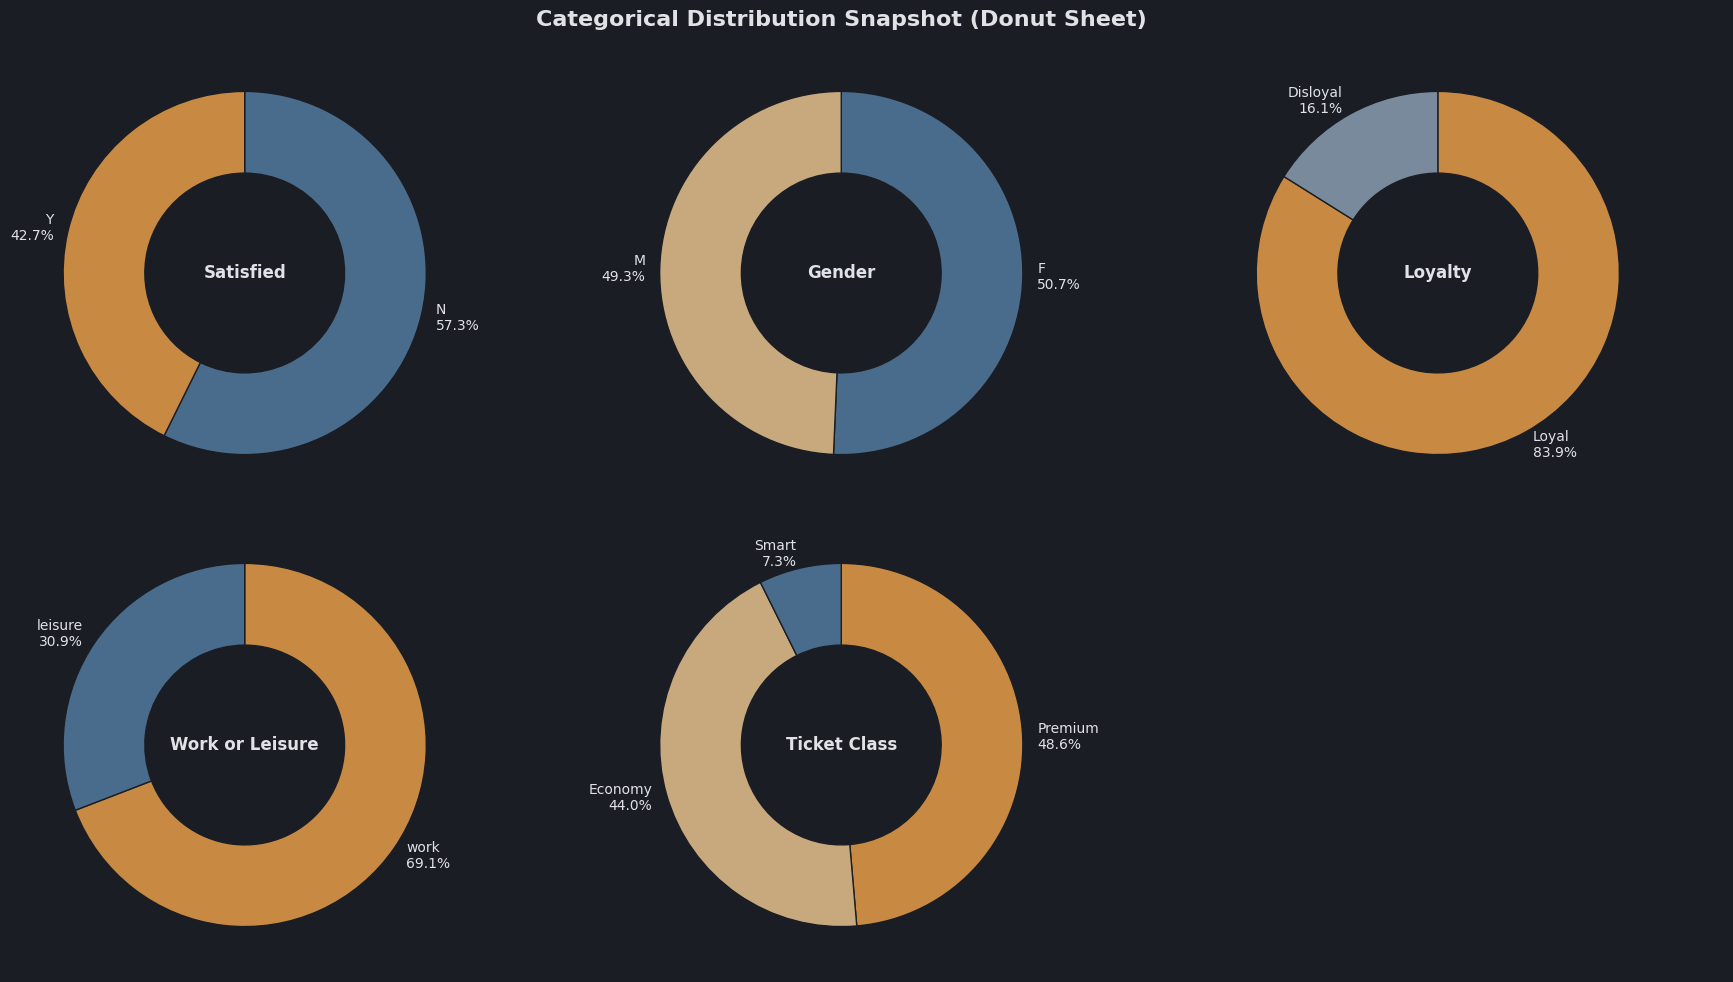

In [8]:
# Plot donut charts for key categorical features.
cat_cols = ['Satisfied', 'Gender', 'Loyalty', 'Work or Leisure', 'Ticket Class']

palette_map = {
    'Satisfied': {
        'N': SATISFIED_PALETTE['N'],
        'Y': SATISFIED_PALETTE['Y'],
        0: SATISFIED_PALETTE['N'],
        1: SATISFIED_PALETTE['Y']
    },
    'Gender': {'M': BASE_PALETTE[1], 'F': BASE_PALETTE[2]},
    'Loyalty': {
        'Loyal Customer': BASE_PALETTE[0],
        'Disloyal Customer': BASE_PALETTE[3],
        'Loyal': BASE_PALETTE[0],
        'Disloyal': BASE_PALETTE[3]
    },
    'Work or Leisure': {
        'Business travel': BASE_PALETTE[0],
        'Personal Travel': BASE_PALETTE[2],
        'work': BASE_PALETTE[0],
        'leisure': BASE_PALETTE[2],
        'Work': BASE_PALETTE[0],
        'Leisure': BASE_PALETTE[2]
    },
    'Ticket Class': {'Premium': BASE_PALETTE[0], 'Economy': BASE_PALETTE[1], 'Smart': BASE_PALETTE[2]}
}

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, col in enumerate(cat_cols):
    ax = axes[i]
    counts = trains_df[col].value_counts(dropna=False)
    labels = [f"{cat}\n{(count / counts.sum()):.1%}" for cat, count in counts.items()]

    palette_lookup = palette_map.get(col, {})
    colors = []
    for idx, cat in enumerate(counts.index):
        mapped = palette_lookup.get(cat, palette_lookup.get(str(cat), BASE_PALETTE[idx % len(BASE_PALETTE)]))
        colors.append(mapped)

    ax.pie(
        counts.values,
        labels=labels,
        startangle=90,
        counterclock=False,
        colors=colors,
        wedgeprops=dict(width=0.45, edgecolor=PLOT_BG),
        labeldistance=1.08,
        textprops={'fontsize': 10, 'color': PLOT_FG}
    )

    ax.text(0, 0, col, ha='center', va='center', fontsize=12, fontweight='bold', color=PLOT_FG)
    ax.set_aspect('equal')
    ax.set_facecolor(PLOT_BG)

for j in range(len(cat_cols), len(axes)):
    axes[j].axis('off')

fig.suptitle('Categorical Distribution Snapshot (Donut Sheet)', fontsize=16, fontweight='bold', y=0.98, color=PLOT_FG)
plt.tight_layout()
plt.show()


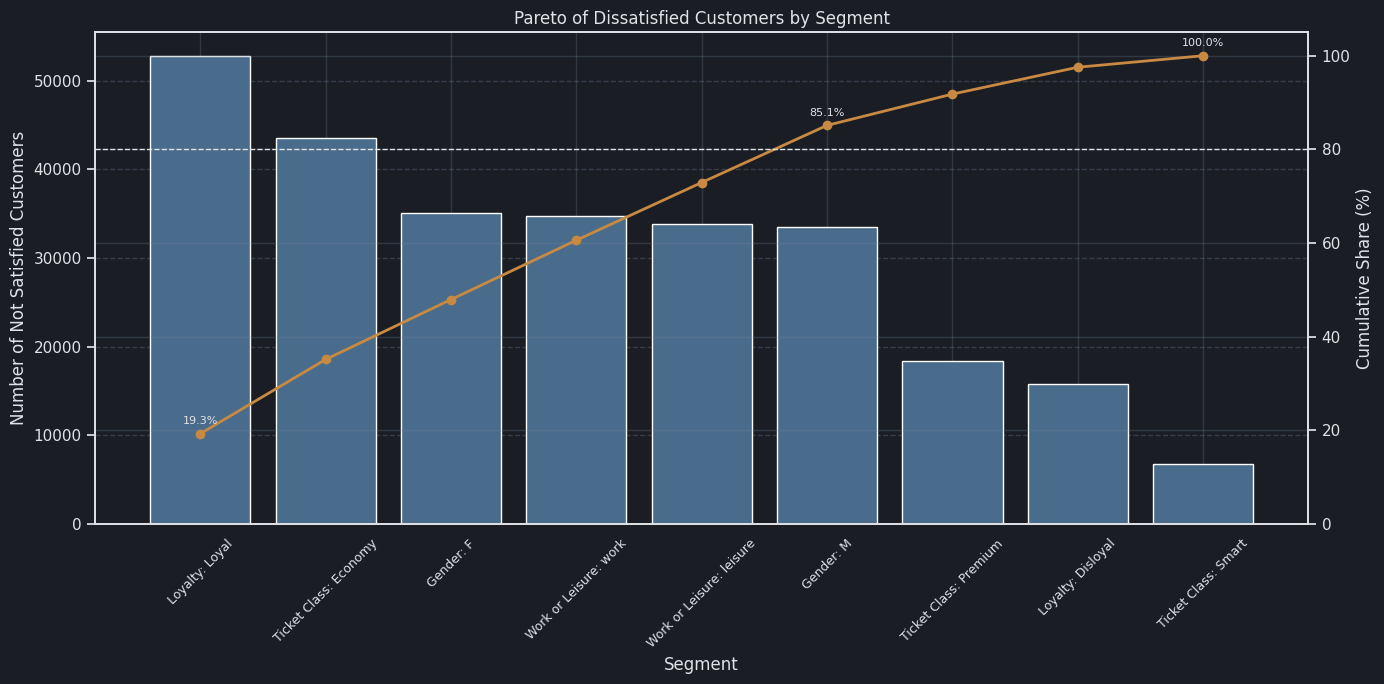

In [9]:
# Build a Pareto chart of dissatisfied-customer volume by segment.
segment_cols = ['Gender', 'Loyalty', 'Work or Leisure', 'Ticket Class']
pareto_rows = []

for col in segment_cols:
    total_counts = trains_df[col].value_counts(dropna=False)
    dissatisfied_counts = trains_df.loc[trains_df['Satisfied'] == 'N', col].value_counts(dropna=False)

    for cat, total in total_counts.items():
        pareto_rows.append({
            'Feature': col,
            'Category': str(cat),
            'Segment': f"{col}: {cat}",
            'Dissatisfied Count': int(dissatisfied_counts.get(cat, 0)),
            'Segment Size': int(total)
        })

pareto_df = pd.DataFrame(pareto_rows).sort_values('Dissatisfied Count', ascending=False).reset_index(drop=True)
pareto_df['Cumulative %'] = pareto_df['Dissatisfied Count'].cumsum() / pareto_df['Dissatisfied Count'].sum() * 100

fig, ax1 = plt.subplots(figsize=(14, 7))
ax1.bar(pareto_df['Segment'], pareto_df['Dissatisfied Count'], color=SATISFIED_PALETTE['N'])
ax1.set_ylabel('Number of Not Satisfied Customers')
ax1.set_xlabel('Segment')
ax1.set_title('Pareto of Dissatisfied Customers by Segment')
ax1.tick_params(axis='x', rotation=45, labelsize=9)
ax1.grid(axis='y', linestyle='--', alpha=0.3, color=BASE_PALETTE[3])

ax2 = ax1.twinx()
ax2.plot(pareto_df['Segment'], pareto_df['Cumulative %'], color=BASE_PALETTE[0], marker='o', linewidth=2)
ax2.axhline(80, color=BASE_PALETTE[-1], linestyle='--', linewidth=1)
ax2.set_ylabel('Cumulative Share (%)')
ax2.set_ylim(0, 105)

cross_80_marked = False
for i, val in enumerate(pareto_df['Cumulative %']):
    if i == 0 or i == len(pareto_df) - 1:
        ax2.text(i, val + 2, f"{val:.1f}%", ha='center', fontsize=8, color=PLOT_FG)
    elif not cross_80_marked and val >= 80:
        ax2.text(i, val + 2, f"{val:.1f}%", ha='center', fontsize=8, color=PLOT_FG)
        cross_80_marked = True

style_axes(ax1)
style_axes(ax2)
plt.tight_layout()
plt.show()


In [10]:
# Build a compact EDA summary that supports the interpretation below.
rating_columns = [col for col in trains_df.columns if col.endswith('Rating')]
high_rating_share = (trains_df[rating_columns] >= 4).mean().mul(100)

sat_share = trains_df['Satisfied'].value_counts(normalize=True)
gender_share = trains_df['Gender'].value_counts(normalize=True)
travel_share = trains_df['Work or Leisure'].value_counts(normalize=True)
loyalty_share = trains_df['Loyalty'].value_counts(normalize=True)
ticket_share = trains_df['Ticket Class'].value_counts(normalize=True)

eda_summary = pd.DataFrame([
    {'Metric': 'Not satisfied (%)', 'Value': round(sat_share.get('N', 0) * 100, 2)},
    {'Metric': 'Satisfied (%)', 'Value': round(sat_share.get('Y', 0) * 100, 2)},
    {'Metric': 'Female share (%)', 'Value': round(gender_share.get('F', 0) * 100, 2)},
    {'Metric': 'Male share (%)', 'Value': round(gender_share.get('M', 0) * 100, 2)},
    {'Metric': 'Work trips (%)', 'Value': round(travel_share.get('work', travel_share.get('Work', 0)) * 100, 2)},
    {'Metric': 'Leisure trips (%)', 'Value': round(travel_share.get('leisure', travel_share.get('Leisure', 0)) * 100, 2)},
    {'Metric': 'Loyal customers (%)', 'Value': round(loyalty_share.get('Loyal', loyalty_share.get('Loyal Customer', 0)) * 100, 2)},
    {'Metric': 'Premium tickets (%)', 'Value': round(ticket_share.get('Premium', 0) * 100, 2)},
    {'Metric': 'Economy tickets (%)', 'Value': round(ticket_share.get('Economy', 0) * 100, 2)},
    {'Metric': 'Smart tickets (%)', 'Value': round(ticket_share.get('Smart', 0) * 100, 2)},
    {'Metric': 'Age min', 'Value': int(trains_df['Age'].min())},
    {'Metric': 'Age max', 'Value': int(trains_df['Age'].max())},
    {'Metric': 'Age mean', 'Value': round(trains_df['Age'].mean(), 2)},
    {'Metric': 'Departure delay median (min)', 'Value': round(trains_df['Departure Delay in Minutes'].median(), 2)},
    {'Metric': 'Arrival delay median (min)', 'Value': round(trains_df['Arrival Delay in Minutes'].median(), 2)},
    {'Metric': 'Departure delay skewness', 'Value': round(trains_df['Departure Delay in Minutes'].skew(), 2)},
    {'Metric': 'Arrival delay skewness', 'Value': round(trains_df['Arrival Delay in Minutes'].dropna().skew(), 2)},
    {'Metric': 'Distance mean (km)', 'Value': round(trains_df['Distance'].mean(), 2)},
    {'Metric': 'Distance std (km)', 'Value': round(trains_df['Distance'].std(), 2)},
    {'Metric': 'Average share of ratings >= 4 (%)', 'Value': round(high_rating_share.mean(), 2)},
    {'Metric': 'Lowest share of ratings >= 4 (%)', 'Value': round(high_rating_share.min(), 2)},
    {'Metric': 'Highest share of ratings >= 4 (%)', 'Value': round(high_rating_share.max(), 2)},
])

display(eda_summary)

rating_variation = (
    high_rating_share.sort_values(ascending=False)
    .rename_axis('Rating Feature')
    .reset_index(name='Share of ratings >= 4 (%)')
)

print('Rating-feature variation (top 3 by share of scores >= 4):')
display(rating_variation.head(3))
print('Rating-feature variation (bottom 3 by share of scores >= 4):')
display(rating_variation.tail(3))


,Metric,Value
0,Not satisfied (%),57.32
1,Satisfied (%),42.68
2,Female share (%),50.68
3,Male share (%),49.32
4,Work trips (%),69.15
5,Leisure trips (%),30.85
6,Loyal customers (%),83.91
7,Premium tickets (%),48.64
8,Economy tickets (%),44.02
9,Smart tickets (%),7.34


Rating-feature variation (top 3 by share of scores >= 4):


,Rating Feature,Share of ratings >= 4 (%)
0,Onboard General Rating,62.687029
1,Baggage Handling Rating,62.147583
2,Seat Comfort Rating,56.661119


Rating-feature variation (bottom 3 by share of scores >= 4):


,Rating Feature,Share of ratings >= 4 (%)
11,Track Location Rating,37.172464
12,Online Booking Rating,33.512591
13,Onboard WiFi Rating,31.012738


##### **Interpretation of Results**

Based on the EDA summary table and charts above, the initial exploration highlights the following patterns:

- **Target balance**: the dataset is moderately imbalanced (`57.32%` not satisfied, `42.68%` satisfied).
- **Ratings profile**: ratings are concentrated in the upper range; on average, `48.69%` of rating values are `4` or `5`, with clear feature-level variation (`31.01%` to `62.69%`).
- **Customer mix**: gender is nearly balanced (`50.68%` female, `49.32%` male), and customer ages range from `7` to `85` (mean `39.86`).
- **Travel purpose**: work trips dominate (`69.15%`) versus leisure trips (`30.85%`).
- **Loyalty**: the majority of customers are loyal (`83.91%`).
- **Ticket class**: Premium (`48.64%`) and Economy (`44.02%`) are the dominant segments, while Smart is smaller (`7.34%`).
- **Delays**: both delay variables are right-skewed (skewness `6.84` departure, `6.70` arrival) with median `0` minutes, indicating many on-time trips and a smaller tail of delayed trips.
- **Distance**: route distance is widely distributed (mean `1223.93` km, standard deviation `999.73` km).


---

##### **Checking Data Integrity**

This section quantifies missing values and defines the handling strategy used before model training.

In [11]:
# Check missing values in the dataset.

nan_count=trains_df.isnull().sum()
print("NaN count in each column :")
nan_count


NaN count in each column :


Legroom Service Rating             0
Onboard General Rating             0
Food'n'Drink Rating                0
Age                                0
Departure Arrival Time Rating      0
Onboard WiFi Rating                0
Ticket ID                          0
Checkin Rating                     0
Track Location Rating              0
Baggage Handling Rating            0
Arrival Delay in Minutes         363
Ticket Class                       0
Loyalty                            0
Gender                             0
Boarding Rating                    0
Online Booking Rating              0
Satisfied                          0
Onboard Entertainment Rating       0
Date and Time                      0
Distance                           0
Seat Comfort Rating                0
Work or Leisure                    0
Departure Delay in Minutes         0
Onboard Service Rating             0
Cleanliness Rating                 0
dtype: int64

##### **Interpretation of Results**

Only `Arrival Delay in Minutes` contains missing values (`363` rows, about `0.30%` of the dataset).

Given the very strong relationship between departure and arrival delays, missing arrival delays are imputed with a linear regression fitted on non-missing records for EDA continuity. For model training, missing-value handling is deferred to the preprocessing pipeline and fit on training data only to avoid leakage.


In [12]:
# Parse the timestamp once and derive reusable time-based features.
trains_df['Date and Time'] = pd.to_datetime(trains_df['Date and Time'], errors='coerce')
trains_df['Travel Month'] = trains_df['Date and Time'].dt.month
trains_df['Travel DayOfWeek'] = trains_df['Date and Time'].dt.day_name()
trains_df['Travel Hour'] = trains_df['Date and Time'].dt.hour
trains_df['Travel Is Weekend'] = trains_df['Date and Time'].dt.dayofweek.isin([5, 6]).astype(int)

---


##### **Correlation Analysis**

This section evaluates relationships between features and the target variable to support interpretation. Correlation results are used as diagnostic evidence, not as an automatic feature-elimination rule.

In [13]:
# Create a copy of the dataset for correlation analysis.
trains_correlation = trains_df.copy()


In [14]:
# Encode the target variable as binary.
trains_correlation['Satisfied'] = trains_correlation['Satisfied'].map({'N': 0, 'Y': 1})


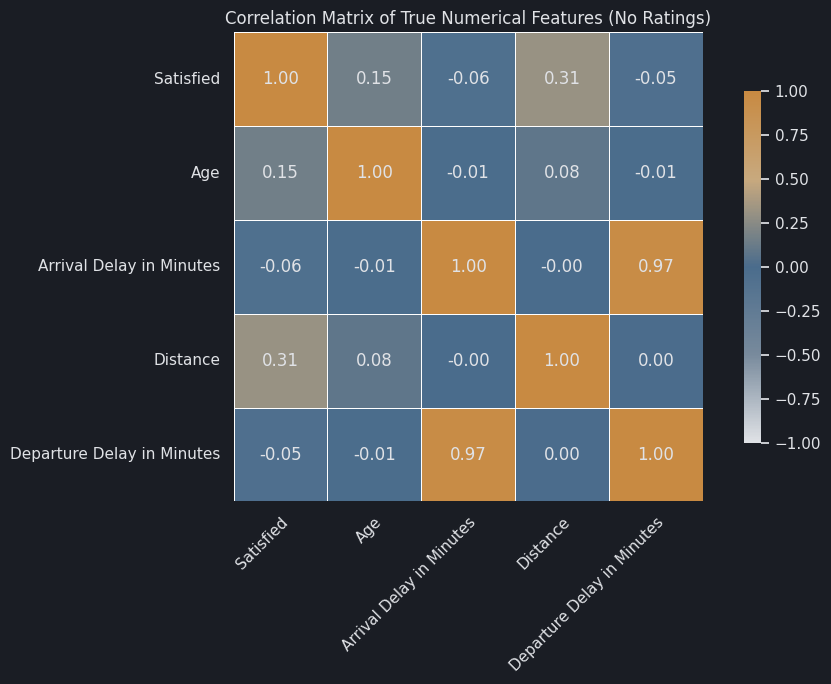

In [15]:
# Select numerical features, excluding rating columns and identifiers.
true_numeric_cols = [
    col for col in trains_correlation.select_dtypes(include=[np.number]).columns
    if ('Rating' not in col) and (col != 'Ticket ID') and (not col.startswith('Travel'))
]

# Compute the full correlation matrix once.
full_correlation_matrix = trains_correlation[true_numeric_cols].corr()

# Place `Satisfied` first on both axes for readability.
feature_cols = [col for col in true_numeric_cols if col != 'Satisfied']
axis_order = ['Satisfied'] + feature_cols
correlation_matrix = full_correlation_matrix.loc[axis_order, axis_order]

# Seaborn maps low->high values left->right in the colormap, so reverse to keep positive->negative as requested.
correlation_cmap = mcolors.LinearSegmentedColormap.from_list(
    'satisfaction_corr',
    list(reversed(CORRELATION_SCALE)),
    N=256
)

f, ax = plt.subplots(figsize=(10, 7))
heatmap = sns.heatmap(
    correlation_matrix,
    cmap=correlation_cmap,
    vmin=-1,
    vmax=1,
    center=0,
    square=True,
    linewidths=.5,
    cbar_kws={"shrink": .75},
    annot=True,
    fmt='.2f'
)

for text in heatmap.texts:
    try:
        value = float(text.get_text())
        text.set_color(PLOT_BG if value <= -0.2 else PLOT_FG)
    except ValueError:
        text.set_color(PLOT_FG)

colorbar = heatmap.collections[0].colorbar
colorbar.ax.tick_params(colors=PLOT_FG)
colorbar.outline.set_edgecolor(PLOT_FG)

style_axes(ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right', rotation_mode='anchor')
plt.title('Correlation Matrix of True Numerical Features (No Ratings)')
plt.tight_layout()
plt.show()


In [16]:
# Extract feature correlations with the target variable.
correlations_with_target = full_correlation_matrix['Satisfied'].sort_values(ascending=False)
correlations_with_target = correlations_with_target.drop(labels='Satisfied', errors='ignore')

# Convert the correlation series to a DataFrame.
correlations_df = correlations_with_target.to_frame(name='Satisfied Correlation')
correlations_df

,Satisfied Correlation
Distance,0.307185
Age,0.152927
Departure Delay in Minutes,-0.050813
Arrival Delay in Minutes,-0.058318


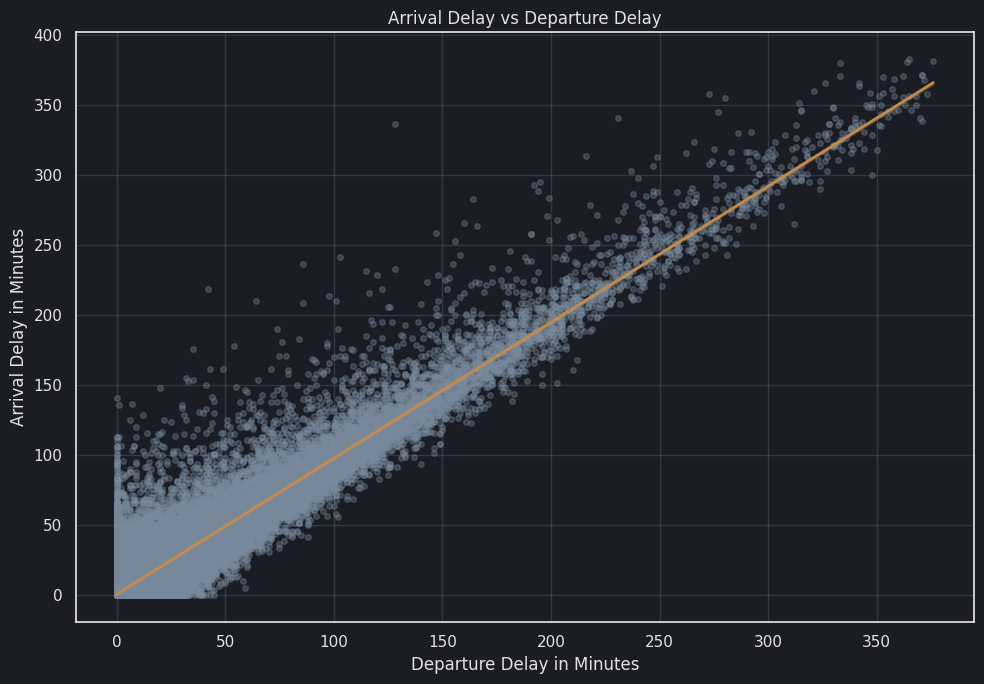

In [17]:
# Trim the extreme upper tail to improve readability of the relationship.
delay_df = trains_correlation[['Departure Delay in Minutes', 'Arrival Delay in Minutes']].dropna()
x_cap = delay_df['Departure Delay in Minutes'].quantile(0.999)
y_cap = delay_df['Arrival Delay in Minutes'].quantile(0.999)
delay_df_clean = delay_df[(delay_df['Departure Delay in Minutes'] <= x_cap) & (delay_df['Arrival Delay in Minutes'] <= y_cap)]

f, ax = plt.subplots(figsize=(10, 7))
sns.regplot(
    data=delay_df_clean,
    x='Departure Delay in Minutes',
    y='Arrival Delay in Minutes',
    scatter_kws={'alpha': 0.35, 's': 16, 'color': BASE_PALETTE[3]},
    line_kws={'color': BASE_PALETTE[0], 'linewidth': 2},
    ax=ax
)

ax.set_title('Arrival Delay vs Departure Delay')
ax.set_xlabel('Departure Delay in Minutes')
ax.set_ylabel('Arrival Delay in Minutes')
style_axes(ax)
plt.tight_layout()
plt.show()

In [18]:
# Impute missing arrival-delay values with linear regression.
# Predict `Arrival Delay in Minutes` from `Departure Delay in Minutes`.
train_mask = trains_df['Arrival Delay in Minutes'].notna() & trains_df['Departure Delay in Minutes'].notna()
slope, intercept = np.polyfit(
    trains_df.loc[train_mask, 'Departure Delay in Minutes'],
    trains_df.loc[train_mask, 'Arrival Delay in Minutes'],
    1
)

trains_nonull = trains_df.copy()
missing_mask = trains_nonull['Arrival Delay in Minutes'].isna() & trains_nonull['Departure Delay in Minutes'].notna()
trains_nonull.loc[missing_mask, 'Arrival Delay in Minutes'] = (
    slope * trains_nonull.loc[missing_mask, 'Departure Delay in Minutes'] + intercept
)

imputed_rows = int(missing_mask.sum())
print(f'Number of imputed rows: {imputed_rows}')

Number of imputed rows: 363


##### **Interpretation of Results**

For the non-rating numerical variables, `Distance` and `Age` show the strongest positive association with `Satisfied`, while departure/arrival delays show weak negative associations. As expected, `Departure Delay in Minutes` and `Arrival Delay in Minutes` are strongly correlated with each other.


In [19]:
# Build the modeling dataset by removing identifier and raw timestamp columns.
# Keep raw missing values so imputation happens inside train-fitted preprocessing.
trains = trains_df.drop(columns=['Ticket ID', 'Date and Time']).copy()
trains


,Legroom Service Rating,Onboard General Rating,Food'n'Drink Rating,Age,Departure Arrival Time Rating,Onboard WiFi Rating,Checkin Rating,Track Location Rating,Baggage Handling Rating,Arrival Delay in Minutes,...,Distance,Seat Comfort Rating,Work or Leisure,Departure Delay in Minutes,Onboard Service Rating,Cleanliness Rating,Travel Month,Travel DayOfWeek,Travel Hour,Travel Is Weekend
0,3,5,5,13,4,3,4,1,4,18.0,...,460,5,leisure,25,4,5,2,Friday,10,0
1,5,4,1,25,2,3,1,3,3,6.0,...,235,1,work,1,1,1,2,Friday,15,0
2,3,4,5,26,2,2,4,2,4,0.0,...,1142,5,work,0,4,5,2,Friday,7,0
3,5,4,2,25,5,2,1,5,3,9.0,...,562,2,work,11,2,2,2,Saturday,8,1
4,4,3,4,61,3,3,3,3,4,0.0,...,214,5,work,0,3,3,2,Saturday,14,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119562,2,5,4,34,3,3,4,1,4,0.0,...,526,4,work,0,3,4,2,Tuesday,5,0
119563,5,5,4,23,4,4,5,4,5,0.0,...,646,4,work,0,4,4,3,Tuesday,2,0
119564,3,4,2,17,5,2,5,5,4,0.0,...,828,2,leisure,0,4,2,2,Saturday,0,1
119565,2,5,4,14,3,3,4,3,5,0.0,...,1127,4,work,0,3,4,2,Thursday,13,0


##### **Interpretation of Results**

Instead of applying a hard correlation threshold, the modeling pipeline keeps the full informative feature set. Only non-predictive or redundant fields are removed (identifier and selected raw/derived time fields), which keeps the workflow traceable and reduces premature feature pruning.


---

In [20]:
def _cramers_v_bias_corrected(contingency):
    """Chi-square + bias-corrected Cramer's V + expected-frequency diagnostics."""
    chi2, p_value, dof, expected = chi2_contingency(contingency, correction=False)

    n = contingency.to_numpy().sum()
    rows, cols = contingency.shape

    if n <= 1:
        return chi2, p_value, dof, np.nan, float(expected.min()), float((expected < 5).mean() * 100)

    phi2 = chi2 / n
    phi2_corr = max(0, phi2 - ((cols - 1) * (rows - 1)) / (n - 1))
    rows_corr = rows - ((rows - 1) ** 2) / (n - 1)
    cols_corr = cols - ((cols - 1) ** 2) / (n - 1)

    denom = min(cols_corr - 1, rows_corr - 1)
    cramers_v = np.sqrt(phi2_corr / denom) if denom > 0 else np.nan

    min_expected = float(expected.min())
    pct_expected_lt_5 = float((expected < 5).mean() * 100)

    return chi2, p_value, dof, cramers_v, min_expected, pct_expected_lt_5

# -------------------------------------------------------------------------
# 1) Canonical EDA DataFrame and type standardization
# -------------------------------------------------------------------------
eda_df = trains_nonull.copy()

# Parse datetime and derive compact time categories for categorical analysis.
if 'Date and Time' in eda_df.columns:
    eda_df['Date and Time'] = pd.to_datetime(eda_df['Date and Time'], errors='coerce')

    eda_df['Travel Month'] = eda_df['Date and Time'].dt.month_name().str[:3]
    eda_df['Travel DayOfWeek'] = eda_df['Date and Time'].dt.day_name()

    eda_df['Travel Day Part'] = pd.cut(
        eda_df['Date and Time'].dt.hour,
        bins=[-1, 5, 11, 17, 23],
        labels=['Night', 'Morning', 'Afternoon', 'Evening']
    )

    eda_df['Travel Is Weekend'] = np.where(
        eda_df['Date and Time'].dt.dayofweek.isin([5, 6]),
        'Weekend',
        'Weekday'
    )

# Map the target to numeric once in this canonical EDA DataFrame.
eda_df['Satisfied_num'] = eda_df['Satisfied'].map({'N': 0, 'Y': 1})
eda_df = eda_df.dropna(subset=['Satisfied_num']).copy()

# Cast low-cardinality features to categorical dtype.
exclude_from_categorical = {'Ticket ID', 'Satisfied', 'Satisfied_num', 'Date and Time'}
categorical_features = []

for col in eda_df.columns:
    if col in exclude_from_categorical:
        continue

    nunique = eda_df[col].nunique(dropna=True)
    is_string_like = (
        pd.api.types.is_object_dtype(eda_df[col])
        or isinstance(eda_df[col].dtype, pd.CategoricalDtype)
        or pd.api.types.is_bool_dtype(eda_df[col])
    )
    is_low_card_numeric = pd.api.types.is_numeric_dtype(eda_df[col]) and nunique <= 12

    if is_string_like or is_low_card_numeric:
        eda_df[col] = eda_df[col].astype('category')
        categorical_features.append(col)

print(f'Categorical features analyzed: {len(categorical_features)}')
print(categorical_features)

# -------------------------------------------------------------------------
# 2) Categorical association table: chi-square, Cramer's V, and diagnostics
# -------------------------------------------------------------------------
association_rows = []
overall_sat_rate = eda_df['Satisfied_num'].mean()

driver_tables = []

for feature in categorical_features:
    tmp = eda_df[[feature, 'Satisfied_num']].dropna().copy()

    # Convert categories to string labels for stable display and plotting.
    tmp[feature] = tmp[feature].astype(str)

    # Need at least 2 categories for a meaningful chi-square test.
    if tmp[feature].nunique() < 2:
        continue

    contingency = pd.crosstab(tmp[feature], tmp['Satisfied_num']).reindex(columns=[0, 1], fill_value=0)

    # Skip degenerate cases where one class is absent.
    if contingency[0].sum() == 0 or contingency[1].sum() == 0:
        continue

    chi2, p_value, dof, cramers_v, min_expected, pct_expected_lt_5 = _cramers_v_bias_corrected(contingency)

    association_rows.append({
        'feature': feature,
        'chi2': chi2,
        'p_value': p_value,
        'dof': dof,
        'cramers_v': cramers_v,
        'min_expected': min_expected,
        'pct_expected_lt_5': pct_expected_lt_5
    })

    # Target-rate driver table for each category value.
    feature_driver = (
        tmp.groupby(feature)['Satisfied_num']
        .agg(n='count', sat_rate='mean')
        .reset_index()
        .rename(columns={feature: 'category'})
    )

    feature_driver['feature'] = feature
    feature_driver['support_pct'] = feature_driver['n'] / feature_driver['n'].sum()
    feature_driver['delta_vs_overall'] = feature_driver['sat_rate'] - overall_sat_rate

    driver_tables.append(feature_driver[['feature', 'category', 'n', 'support_pct', 'sat_rate', 'delta_vs_overall']])

association_summary = pd.DataFrame(association_rows)

if not association_summary.empty:
    association_summary = association_summary.sort_values('cramers_v', ascending=False).reset_index(drop=True)

categorical_target_driver_table = (
    pd.concat(driver_tables, ignore_index=True)
    if len(driver_tables) > 0
    else pd.DataFrame(columns=['feature', 'category', 'n', 'support_pct', 'sat_rate', 'delta_vs_overall'])
)

if not categorical_target_driver_table.empty:
    categorical_target_driver_table = categorical_target_driver_table.sort_values(
        ['feature', 'delta_vs_overall'],
        ascending=[True, False]
    ).reset_index(drop=True)

print('\nAssociation summary table (sorted by Cramers V):')
display(association_summary)

print('\nTarget-rate driver table:')
display(categorical_target_driver_table)



Categorical features analyzed: 22
['Legroom Service Rating', 'Onboard General Rating', "Food'n'Drink Rating", 'Departure Arrival Time Rating', 'Onboard WiFi Rating', 'Checkin Rating', 'Track Location Rating', 'Baggage Handling Rating', 'Ticket Class', 'Loyalty', 'Gender', 'Boarding Rating', 'Online Booking Rating', 'Onboard Entertainment Rating', 'Seat Comfort Rating', 'Work or Leisure', 'Onboard Service Rating', 'Cleanliness Rating', 'Travel Month', 'Travel DayOfWeek', 'Travel Is Weekend', 'Travel Day Part']

Association summary table (sorted by Cramers V):


,feature,chi2,p_value,dof,cramers_v,min_expected,pct_expected_lt_5
0,Boarding Rating,47139.753482,0.000000e+00,4,0.627872,5269.149347,0.0
1,Ticket Class,30963.586398,0.000000e+00,2,0.508871,3746.789415,0.0
2,Onboard WiFi Rating,27988.678146,0.000000e+00,4,0.483789,5800.502898,0.0
3,Work or Leisure,25661.842969,0.000000e+00,1,0.463267,15744.709912,0.0
4,Onboard Entertainment Rating,25616.663923,0.000000e+00,4,0.462832,5956.708038,0.0
5,Seat Comfort Rating,20474.161960,0.000000e+00,4,0.413768,5767.640068,0.0
6,Legroom Service Rating,16644.808695,0.000000e+00,4,0.373064,4988.748317,0.0
7,Onboard Service Rating,15546.409256,0.000000e+00,4,0.360542,5763.798958,0.0
8,Cleanliness Rating,13818.343674,0.000000e+00,4,0.339908,6498.304549,0.0
9,Baggage Handling Rating,11569.661477,0.000000e+00,4,0.311015,3375.908905,0.0



Target-rate driver table:


,feature,category,n,support_pct,sat_rate,delta_vs_overall
0,Baggage Handling Rating,5,30854,0.258048,0.622059,0.195269
1,Baggage Handling Rating,4,43454,0.363428,0.478506,0.051716
2,Baggage Handling Rating,2,13138,0.109880,0.271426,-0.155364
3,Baggage Handling Rating,1,7910,0.066155,0.266498,-0.160292
4,Baggage Handling Rating,3,24211,0.202489,0.221800,-0.204990
...,...,...,...,...,...,...
89,Travel Is Weekend,Weekend,30655,0.256383,0.425510,-0.001280
90,Travel Month,Mar,5882,0.049194,0.435736,0.008946
91,Travel Month,Feb,113685,0.950806,0.426327,-0.000463
92,Work or Leisure,work,82676,0.691462,0.579854,0.153064


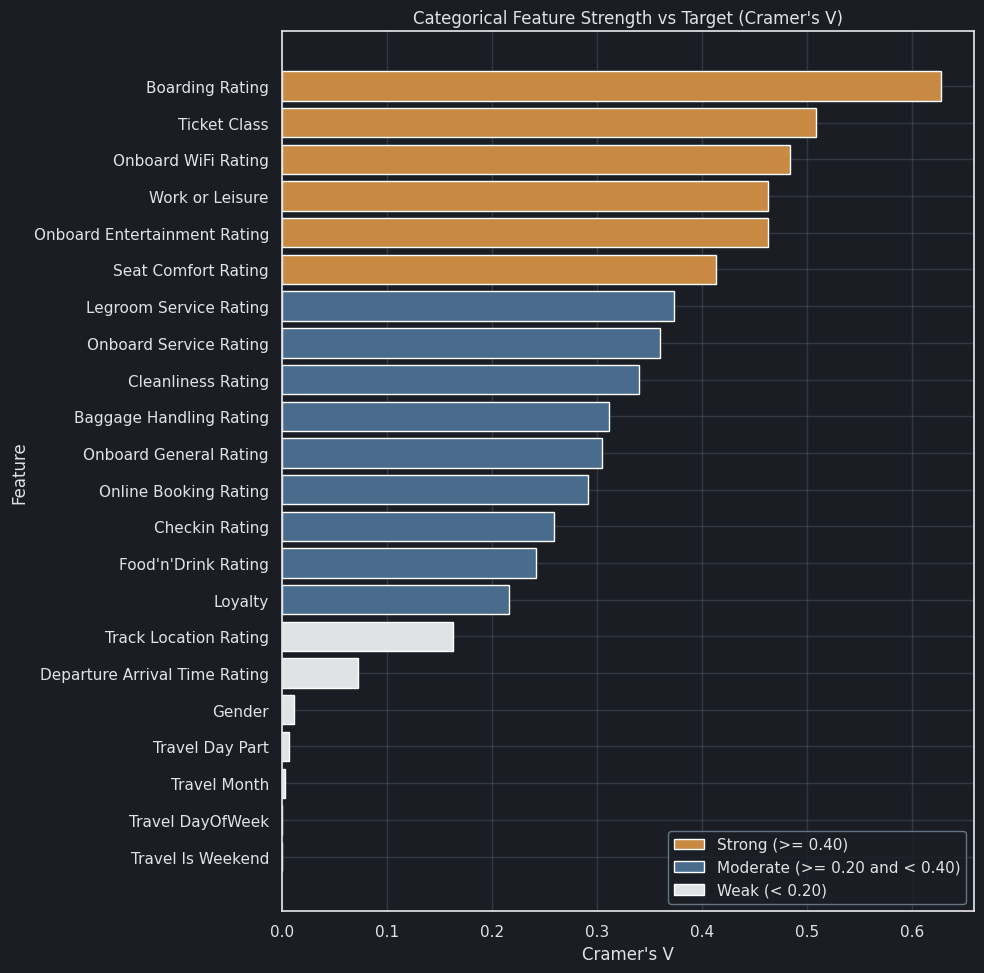

In [21]:
# Plot Cramer's V strength by categorical feature.

if association_summary.empty:
    print('No categorical associations available to plot.')
else:
    cv_plot_df = association_summary[['feature', 'cramers_v']].copy()
    cv_plot_df = cv_plot_df.dropna(subset=['cramers_v'])

    if cv_plot_df.empty:
        print('No valid Cramers V values available to plot.')
    else:
        cv_plot_df = cv_plot_df.sort_values('cramers_v', ascending=False)

        def cv_strength_color(v):
            if v >= 0.40:
                return STRENGTH_PALETTE['Strong']
            elif v >= 0.20:
                return STRENGTH_PALETTE['Moderate']
            return STRENGTH_PALETTE['Weak']

        colors = cv_plot_df['cramers_v'].apply(cv_strength_color)

        fig, ax = plt.subplots(figsize=(10, max(4, len(cv_plot_df) * 0.45)))
        ax.barh(cv_plot_df['feature'], cv_plot_df['cramers_v'], color=colors)
        ax.invert_yaxis()
        ax.set_xlabel("Cramer's V")
        ax.set_ylabel('Feature')
        ax.set_title("Categorical Feature Strength vs Target (Cramer's V)")

        legend_items = [
            Patch(facecolor=STRENGTH_PALETTE['Strong'], label='Strong (>= 0.40)'),
            Patch(facecolor=STRENGTH_PALETTE['Moderate'], label='Moderate (>= 0.20 and < 0.40)'),
            Patch(facecolor=STRENGTH_PALETTE['Weak'], label='Weak (< 0.20)')
        ]
        legend = ax.legend(handles=legend_items, loc='lower right')
        style_legend(legend)
        style_axes(ax)
        plt.tight_layout()
        plt.show()


In [22]:
# Build top and bottom feature-category satisfaction tables.

if categorical_target_driver_table.empty:
    print('No categorical target-driver data available to build top/low tables.')
else:
    filtered_driver = categorical_target_driver_table[categorical_target_driver_table['n'] > 100].copy()

    if filtered_driver.empty:
        print('No feature-category rows found with n > 100.')
    else:
        # For each feature, keep the category with the highest satisfaction rate.
        best_per_feature = (
            filtered_driver
            .sort_values(['feature', 'sat_rate', 'n'], ascending=[True, False, False])
            .drop_duplicates(subset='feature', keep='first')
        )

        top_10_best_feature_categories = (
            best_per_feature
            .sort_values(['sat_rate', 'n'], ascending=[False, False])
            .head(10)
            .reset_index(drop=True)
        )

        # For each feature, keep the category with the lowest satisfaction rate.
        worst_per_feature = (
            filtered_driver
            .sort_values(['feature', 'sat_rate', 'n'], ascending=[True, True, False])
            .drop_duplicates(subset='feature', keep='first')
        )

        top_10_lowest_feature_categories = (
            worst_per_feature
            .sort_values(['sat_rate', 'n'], ascending=[True, False])
            .head(10)
            .reset_index(drop=True)
        )

        cols_to_show = ['feature', 'category', 'sat_rate', 'n', 'support_pct', 'delta_vs_overall']

        print('Top 10 highest satisfaction (best category per feature, n > 100):')
        display(top_10_best_feature_categories[cols_to_show])

        print('Top 10 lowest satisfaction (worst category per feature, n > 100):')
        display(top_10_lowest_feature_categories[cols_to_show])


Top 10 highest satisfaction (best category per feature, n > 100):


,feature,category,sat_rate,n,support_pct,delta_vs_overall
0,Onboard WiFi Rating,5,0.989625,13591,0.113668,0.562835
1,Boarding Rating,5,0.871183,24329,0.203476,0.444393
2,Online Booking Rating,5,0.725567,16678,0.139487,0.298777
3,Ticket Class,Premium,0.684991,58157,0.486397,0.258201
4,Onboard Entertainment Rating,5,0.658874,29388,0.245787,0.232084
5,Seat Comfort Rating,5,0.655807,30663,0.256450,0.229017
6,Onboard Service Rating,5,0.654849,27078,0.226467,0.228059
7,Baggage Handling Rating,5,0.622059,30854,0.258048,0.195269
8,Legroom Service Rating,5,0.619908,28772,0.240635,0.193118
9,Onboard General Rating,5,0.617136,31058,0.259754,0.190346


Top 10 lowest satisfaction (worst category per feature, n > 100):


,feature,category,sat_rate,n,support_pct,delta_vs_overall
0,Work or Leisure,leisure,0.083760,36891,0.308538,-0.343030
1,Onboard Entertainment Rating,1,0.097370,13957,0.116730,-0.329420
2,Boarding Rating,2,0.111961,20784,0.173827,-0.314829
3,Onboard Service Rating,1,0.170233,13505,0.112949,-0.256557
4,Cleanliness Rating,1,0.171155,15226,0.127343,-0.255635
5,Legroom Service Rating,1,0.171871,11689,0.097761,-0.254919
6,Food'n'Drink Rating,1,0.173752,14584,0.121973,-0.253038
7,Ticket Class,Economy,0.173871,52631,0.440180,-0.252919
8,Loyalty,Disloyal,0.182229,19234,0.160864,-0.244561
9,Seat Comfort Rating,1,0.194465,13514,0.113024,-0.232325


In [23]:
# Remove derived day-of-week indicators from the modeling dataset.
trains = trains.drop(columns=['Travel DayOfWeek', 'Travel Is Weekend'])
trains

,Legroom Service Rating,Onboard General Rating,Food'n'Drink Rating,Age,Departure Arrival Time Rating,Onboard WiFi Rating,Checkin Rating,Track Location Rating,Baggage Handling Rating,Arrival Delay in Minutes,...,Satisfied,Onboard Entertainment Rating,Distance,Seat Comfort Rating,Work or Leisure,Departure Delay in Minutes,Onboard Service Rating,Cleanliness Rating,Travel Month,Travel Hour
0,3,5,5,13,4,3,4,1,4,18.0,...,N,5,460,5,leisure,25,4,5,2,10
1,5,4,1,25,2,3,1,3,3,6.0,...,N,1,235,1,work,1,1,1,2,15
2,3,4,5,26,2,2,4,2,4,0.0,...,Y,5,1142,5,work,0,4,5,2,7
3,5,4,2,25,5,2,1,5,3,9.0,...,N,2,562,2,work,11,2,2,2,8
4,4,3,4,61,3,3,3,3,4,0.0,...,Y,3,214,5,work,0,3,3,2,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119562,2,5,4,34,3,3,4,1,4,0.0,...,N,4,526,4,work,0,3,4,2,5
119563,5,5,4,23,4,4,5,4,5,0.0,...,Y,4,646,4,work,0,4,4,3,2
119564,3,4,2,17,5,2,5,5,4,0.0,...,N,2,828,2,leisure,0,4,2,2,0
119565,2,5,4,14,3,3,4,3,5,0.0,...,Y,4,1127,4,work,0,3,4,2,13


##### **Interpretation of Results**

The categorical-association analysis and driver tables indicate that satisfaction is primarily driven by service-experience quality and trip segment.

- **Strongest categorical drivers (Cramer's V)** are `Boarding Rating` (`0.628`), `Ticket Class` (`0.509`), `Onboard WiFi Rating` (`0.484`), `Work or Leisure` (`0.463`), and `Onboard Entertainment Rating` (`0.463`).
- **Highest-satisfaction categories** are concentrated in top service scores, especially `Onboard WiFi Rating = 5` (`sat_rate 98.96%`) and `Boarding Rating = 5` (`87.12%`).
- **Segment effect is material**: `Ticket Class = Premium` is associated with higher satisfaction (`68.50%`), while `Ticket Class = Economy` is associated with lower satisfaction (`17.39%`).
- **Lowest-satisfaction categories** include `Work or Leisure = leisure` (`8.38%`) and rating level `1` across multiple service dimensions (for example entertainment, cleanliness, legroom, onboard service).
- These results are consistent with a clear business pattern: improving high-impact service dimensions (boarding flow, Wi-Fi quality, entertainment/comfort) and reducing Economy/Leisure pain points should have the strongest effect on dissatisfaction reduction.


---


## **Data Processing**

---


##### **Partitioning the Dataset into Training and Test Sets**

The dataset is split into features (`X`) and target (`y`), then divided into training and test sets with a stratified `80/20` split.

This setup ensures unbiased final evaluation on unseen data while preserving class proportions across splits.


In [24]:
# Set a reproducibility seed for splits and stochastic models.
RANDOM_STATE = 25

# Split the dataset into features and target.
x = trains.drop('Satisfied', axis=1)
y = trains['Satisfied'].map({'N': 0, 'Y': 1})

# Create stratified training and test splits.
train, test, train_check, test_check = train_test_split(x, y, test_size=0.2, random_state=RANDOM_STATE, stratify=y)


---


##### **Preprocessing and Scaling**

Preprocessing standardizes numerical features and one-hot encodes categorical features.

Standardization prevents large-scale numeric variables from dominating distance-based or gradient-based learning behavior, while one-hot encoding converts categorical features into model-ready numeric vectors.

In [25]:
# Identify numerical and categorical feature columns.
numerical_columns_lst = x.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_columns_lst = x.select_dtypes(include=['object']).columns.tolist()


A preprocessing pipeline is defined with `ColumnTransformer` so that linear-regression delay imputation, encoding, and scaling are fitted on training data only and applied consistently to validation and test sets.

In [26]:
# Define a leakage-safe imputer that reproduces the linear delay imputation logic.
class ArrivalDelayLinearRegImputer(BaseEstimator, TransformerMixin):
    def __init__(self, arrival_col='Arrival Delay in Minutes', departure_col='Departure Delay in Minutes'):
        self.arrival_col = arrival_col
        self.departure_col = departure_col

    def fit(self, X, y=None):
        X_df = X.copy()
        if self.arrival_col not in X_df.columns or self.departure_col not in X_df.columns:
            raise KeyError("Required delay columns are missing from numerical features.")

        fit_mask = X_df[self.arrival_col].notna() & X_df[self.departure_col].notna()
        if fit_mask.sum() < 2:
            raise ValueError("Not enough rows to fit linear-regression delay imputation.")

        self.delay_model_ = LinearRegression()
        self.delay_model_.fit(
            X_df.loc[fit_mask, [self.departure_col]],
            X_df.loc[fit_mask, self.arrival_col]
        )
        return self

    def transform(self, X):
        X_df = X.copy()
        missing_mask = X_df[self.arrival_col].isna() & X_df[self.departure_col].notna()
        if missing_mask.any():
            X_df.loc[missing_mask, self.arrival_col] = self.delay_model_.predict(
                X_df.loc[missing_mask, [self.departure_col]]
            )
        return X_df

# Define preprocessing pipelines for numerical and categorical features.
numerical_transformer = Pipeline(steps=[
    ('arrival_delay_imputer', ArrivalDelayLinearRegImputer()),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# Combine preprocessing steps with a `ColumnTransformer`.
transformation = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_columns_lst),
        ('cat', categorical_transformer, categorical_columns_lst)
    ])

# Wrap preprocessing in a reusable pipeline.
model_pipeline = Pipeline(steps=[('transformation', transformation)])


---


##### **Partitioning the Development Set into Training-Core and Validation Sets**

The training portion is further split into a training-core subset and a validation subset.

The training-core data is used to fit models, while the validation set is used for model comparison and hyperparameter tuning decisions before the final test evaluation.


In [27]:
# Split the development set into training-core and validation subsets.
training_raw, validation_raw, training_check, validation_test_check = train_test_split(
    train, train_check, test_size=0.2, random_state=RANDOM_STATE, stratify=train_check)

# Fit preprocessing on the training core, then transform validation and test sets.
training = model_pipeline.fit_transform(training_raw)
validation_test = model_pipeline.transform(validation_raw)
test_encoded = model_pipeline.transform(test)


---


## **Modeling**

---

This is a binary classification problem (`Satisfied`: `Y`/`N`). We benchmark four model families to compare linear and non-linear behavior:

- **Logistic Regression**: interpretable linear baseline.
- **K-Nearest Neighbors (KNN)**: instance-based model that captures local similarity structure.
- **Decision Tree**: non-linear rule-based model that captures feature interactions.
- **Random Forest**: tree ensemble that improves stability and predictive performance over a single tree.


Each model is evaluated with five metrics: **Accuracy**, **Precision**, **Recall**, **F1 Score**, and **AUC**.

Using multiple metrics provides a balanced view of performance rather than relying on a single score.

---


##### **Logistic Regression**


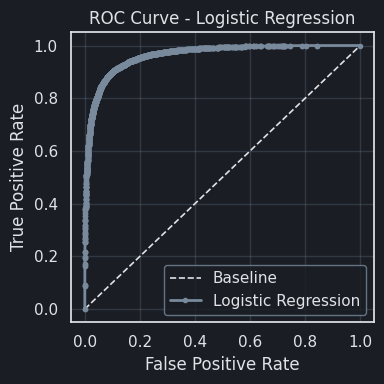

,Model,Accuracy,Precision,Recall,F1 Score,AUC
0,Logistic Regression,0.900528,0.88295,0.88414,0.883544,0.963131


In [28]:
# Build LR-specific matrices without `Arrival Delay in Minutes`.
arrival_delay_idx = numerical_columns_lst.index('Arrival Delay in Minutes')
keep_columns_lr = [idx for idx in range(training.shape[1]) if idx != arrival_delay_idx]
training_lr = training[:, keep_columns_lr]
validation_test_lr = validation_test[:, keep_columns_lr]

# Initialize the model.
Logistic_Regression = LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)

# Train the model.
Logistic_Regression.fit(training_lr, training_check)

# Generate validation predictions and probabilities.
prediction_LR = Logistic_Regression.predict(validation_test_lr)
score_LR = Logistic_Regression.predict_proba(validation_test_lr)[:, 1]

# Compute performance metrics.
accuracy_LR = accuracy_score(validation_test_check, prediction_LR)
precision_LR = precision_score(validation_test_check, prediction_LR)
recall_LR = recall_score(validation_test_check, prediction_LR)
f1_LR = f1_score(validation_test_check, prediction_LR)

# Compute ROC curve coordinates and ROC-AUC.
fpr, tpr, thresholds = roc_curve(validation_test_check, score_LR)
auc_LR = roc_auc_score(validation_test_check, score_LR)

# Plot the ROC curve.
plot_roc_custom(fpr, tpr, 'Logistic Regression')

# Store the results in a DataFrame.
results_lr = pd.DataFrame(data=[['Logistic Regression', accuracy_LR, precision_LR, recall_LR, f1_LR, auc_LR]],
                        columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC'])
results_lr


In [29]:
cm = confusion_matrix(validation_test_check, prediction_LR)
cm = pd.DataFrame(cm, index=['Actual Negative', 'Actual Positive'], columns=['Predicted Negative', 'Predicted Positive'])
cm


,Predicted Negative,Predicted Positive
Actual Negative,10009,957
Actual Positive,946,7219


---


##### **K-Nearest Neighbors (KNN)**


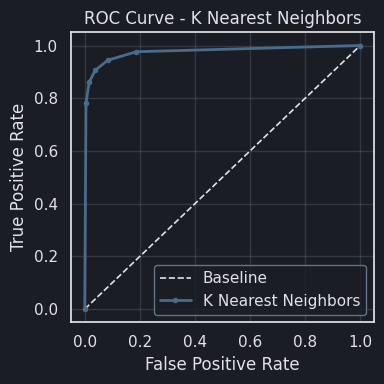

,Model,Accuracy,Precision,Recall,F1 Score,AUC
0,K Nearest Neighbors,0.938111,0.94607,0.906675,0.925954,0.975558


In [30]:
# Initialize the model.
KNN = KNeighborsClassifier()

# Train the model.
KNN.fit(training, training_check)

# Generate validation predictions and probabilities.
prediction_KNN = KNN.predict(validation_test)
score_KNN = KNN.predict_proba(validation_test)[:, 1]

# Compute performance metrics.
accuracy_KNN = accuracy_score(validation_test_check, prediction_KNN)
precision_KNN = precision_score(validation_test_check, prediction_KNN)
recall_KNN = recall_score(validation_test_check, prediction_KNN)
f1_KNN = f1_score(validation_test_check, prediction_KNN)

# Compute ROC curve coordinates and ROC-AUC.
fpr, tpr, thresholds = roc_curve(validation_test_check, score_KNN)
auc_KNN = roc_auc_score(validation_test_check, score_KNN)

# Plot the ROC curve.
plot_roc_custom(fpr, tpr, 'K Nearest Neighbors')

# Store the results in a DataFrame.
results_knn_val = pd.DataFrame(data=[['K Nearest Neighbors', accuracy_KNN, precision_KNN, recall_KNN, f1_KNN, auc_KNN]],
                        columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC'])
results_knn_val


In [31]:
cm = confusion_matrix(validation_test_check, prediction_KNN)
cm = pd.DataFrame(cm, index=['Actual Negative', 'Actual Positive'], columns=['Predicted Negative', 'Predicted Positive'])
cm


,Predicted Negative,Predicted Positive
Actual Negative,10544,422
Actual Positive,762,7403


---


##### **Decision Tree**


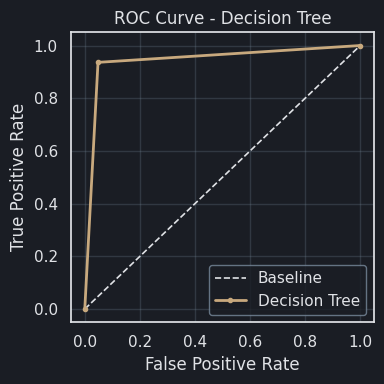

,Model,Accuracy,Precision,Recall,F1 Score,AUC
0,Decision Tree,0.945168,0.935496,0.936069,0.935782,0.944005


In [32]:
# Initialize the model.
Decision_Tree = DecisionTreeClassifier(random_state=RANDOM_STATE)

# Train the model.
Decision_Tree.fit(training, training_check)

# Generate validation predictions and probabilities.
prediction_DT = Decision_Tree.predict(validation_test)
score_DT = Decision_Tree.predict_proba(validation_test)[:, 1]

# Compute performance metrics.
accuracy_DT = accuracy_score(validation_test_check, prediction_DT)
precision_DT = precision_score(validation_test_check, prediction_DT)
recall_DT = recall_score(validation_test_check, prediction_DT)
f1_DT = f1_score(validation_test_check, prediction_DT)

# Compute ROC curve coordinates and ROC-AUC.
fpr, tpr, thresholds = roc_curve(validation_test_check, score_DT)
auc_DT = roc_auc_score(validation_test_check, score_DT)

# Plot the ROC curve.
plot_roc_custom(fpr, tpr, 'Decision Tree')

# Store the results in a DataFrame.
results_dt_val = pd.DataFrame(data=[['Decision Tree', accuracy_DT, precision_DT, recall_DT, f1_DT, auc_DT]],
                        columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC'])
results_dt_val


In [33]:
cm = confusion_matrix(validation_test_check, prediction_DT)
cm = pd.DataFrame(cm, index=['Actual Negative', 'Actual Positive'], columns=['Predicted Negative', 'Predicted Positive'])
cm


,Predicted Negative,Predicted Positive
Actual Negative,10439,527
Actual Positive,522,7643


---


##### **Random Forest**


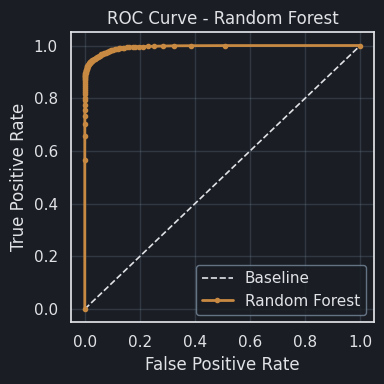

,Model,Accuracy,Precision,Recall,F1 Score,AUC
0,Random Forest,0.961163,0.971059,0.936926,0.953687,0.993984


In [34]:
# Initialize the model.
Random_Forest = RandomForestClassifier(n_jobs=-1, random_state=RANDOM_STATE)

# Train the model.
Random_Forest.fit(training, training_check)

# Generate validation predictions and probabilities.
prediction_RF = Random_Forest.predict(validation_test)
score_RF = Random_Forest.predict_proba(validation_test)[:, 1]

# Compute performance metrics.
accuracy_RF = accuracy_score(validation_test_check, prediction_RF)
precision_RF = precision_score(validation_test_check, prediction_RF)
recall_RF = recall_score(validation_test_check, prediction_RF)
f1_RF = f1_score(validation_test_check, prediction_RF)

# Compute ROC curve coordinates and ROC-AUC.
fpr, tpr, thresholds = roc_curve(validation_test_check, score_RF)
auc_RF = roc_auc_score(validation_test_check, score_RF)

# Plot the ROC curve.
plot_roc_custom(fpr, tpr, 'Random Forest')

# Store the results in a DataFrame.
results_rf_val = pd.DataFrame(data=[['Random Forest', accuracy_RF, precision_RF, recall_RF, f1_RF, auc_RF]],
                        columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC'])
results_rf_val


In [35]:
cm = confusion_matrix(validation_test_check, prediction_RF)
cm = pd.DataFrame(cm, index=['Actual Negative', 'Actual Positive'], columns=['Predicted Negative', 'Predicted Positive'])
cm


,Predicted Negative,Predicted Positive
Actual Negative,10738,228
Actual Positive,515,7650


---


In [36]:
# Combine model metrics into a single validation-results DataFrame.
validation_results = pd.concat([results_lr, results_knn_val, results_dt_val, results_rf_val], ignore_index=True)
validation_results = validation_results.sort_values(by='Accuracy', ascending=False)
validation_results


,Model,Accuracy,Precision,Recall,F1 Score,AUC
3,Random Forest,0.961163,0.971059,0.936926,0.953687,0.993984
2,Decision Tree,0.945168,0.935496,0.936069,0.935782,0.944005
1,K Nearest Neighbors,0.938111,0.946070,0.906675,0.925954,0.975558
0,Logistic Regression,0.900528,0.882950,0.884140,0.883544,0.963131


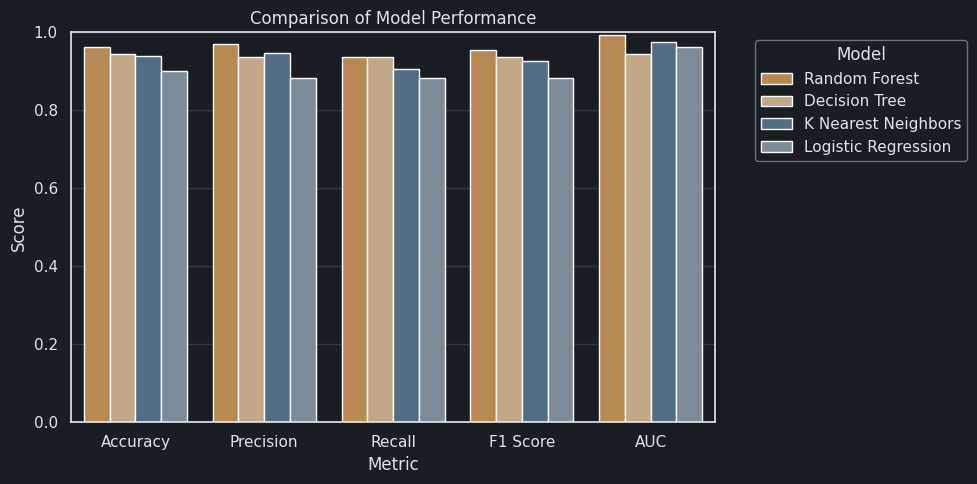

In [37]:
# Assemble model metrics for visualization.
metrics_dictionary = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC'],
    'Random Forest': [accuracy_RF, precision_RF, recall_RF, f1_RF, auc_RF],
    'Decision Tree': [accuracy_DT, precision_DT, recall_DT, f1_DT, auc_DT],
    'K Nearest Neighbors': [accuracy_KNN, precision_KNN, recall_KNN, f1_KNN, auc_KNN],
    'Logistic Regression': [accuracy_LR, precision_LR, recall_LR, f1_LR, auc_LR]
}
metrics_df = pd.DataFrame(metrics_dictionary)

# Reshape the DataFrame to long format for Seaborn.
df_long = pd.melt(metrics_df, id_vars=['Metric'], value_vars=['Random Forest', 'Decision Tree', 'K Nearest Neighbors', 'Logistic Regression'],
                  var_name='Model', value_name='Score')

# Plot the model-metric comparison.
model_order = ['Random Forest', 'Decision Tree', 'K Nearest Neighbors', 'Logistic Regression']
plt.figure(figsize=(10, 5))
ax = sns.barplot(
    x='Metric',
    y='Score',
    hue='Model',
    hue_order=model_order,
    data=df_long,
    palette={m: MODEL_PALETTE[m] for m in model_order}
)

# Move the legend outside the plot to avoid overlap.
legend = plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
style_legend(legend)

plt.title('Comparison of Model Performance')
plt.ylabel('Score')
plt.ylim(0, 1)
style_axes(ax)

# Render the plot.
plt.tight_layout()
plt.show()


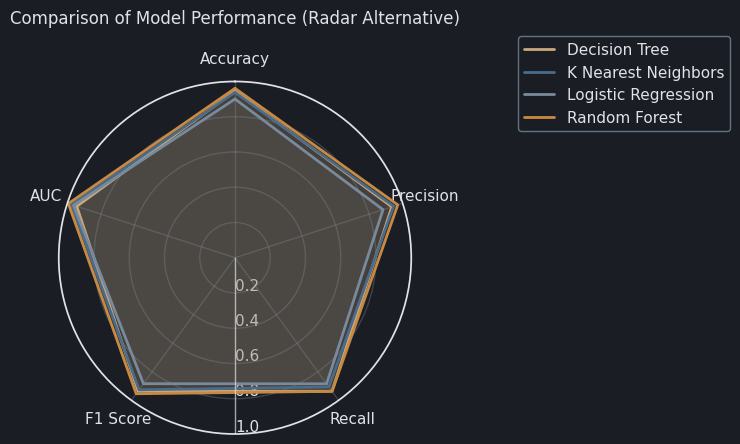

In [38]:
# Shared palette and metric order for radar-based model comparison plots.
MODEL_PALETTE = {
    'Random Forest': '#c88a42',
    'Decision Tree': '#c8a97e',
    'K Nearest Neighbors': '#4a6c8c',
    'Logistic Regression': '#788a9c'
}

RADAR_METRICS = ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC']

# Helper functions used across radar, delta, and dumbbell visualizations.
def _close_radar(values):
    return values + values[:1]

def _radar_angles(num_metrics):
    angles = np.linspace(0, 2 * np.pi, num_metrics, endpoint=False).tolist()
    return angles + angles[:1]

def _blend_with_white(color, blend=0.5):
    rgb = np.array(mcolors.to_rgb(color))
    return tuple(rgb * (1 - blend) + blend)

def _radar_ticks(rmin, rmax):
    if np.isclose(rmin, 0.0):
        return [0.2, 0.4, 0.6, 0.8, 1.0]
    if np.isclose(rmin, 0.70) and np.isclose(rmax, 1.0):
        return [0.7, 0.8, 0.9, 1.0]
    step = 0.05
    start = np.ceil(rmin / step) * step
    ticks = np.arange(start, rmax + 1e-9, step).round(2).tolist()
    if len(ticks) == 0 or ticks[-1] < round(rmax, 2):
        ticks.append(round(rmax, 2))
    return ticks

def _configure_radar_axis(ax, angles, metric_labels, rmin, rmax, title):
    # Configure a radar layout with the first metric at the top and clockwise ordering.
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(metric_labels, color=PLOT_FG)

    # Place radial tick labels on the bottom axis for readability.
    ax.set_ylim(rmin, rmax)
    ticks = _radar_ticks(rmin, rmax)
    ax.set_yticks(ticks)
    if np.isclose(rmin, 0.0) or (np.isclose(rmin, 0.70) and np.isclose(rmax, 1.0)):
        ax.set_yticklabels([f'{t:.1f}' for t in ticks], color=PLOT_FG)
    else:
        ax.set_yticklabels([f'{t:.2f}' for t in ticks], color=PLOT_FG)

    # With this theta orientation, 180 degrees corresponds to the bottom axis.
    ax.set_rlabel_position(180)
    theta_bottom = np.deg2rad(180)
    ax.plot([theta_bottom, theta_bottom], [rmin, rmax], color=PLOT_FG, linewidth=1.0, alpha=0.7)

    ax.set_title(title, pad=20, color=PLOT_FG)
    ax.grid(color=BASE_PALETTE[3], alpha=0.35)
    ax.set_facecolor(PLOT_BG)
    ax.spines['polar'].set_color(PLOT_FG)

def _order_metrics(pivot, metric_order=None):
    order = RADAR_METRICS if metric_order is None else metric_order
    order = [m for m in order if m in pivot.columns]
    return pivot.reindex(columns=order), order

def plot_radar_from_pivot(
    pivot,
    title,
    rmin=0.0,
    rmax=1.0,
    legend_bbox=(1.28, 1.15),
    palette=None,
    fill_alpha=0.12,
    line_styles=None,
    fill_alpha_map=None,
):
    palette = MODEL_PALETTE if palette is None else palette
    pivot, metric_labels = _order_metrics(pivot, RADAR_METRICS)
    angles = _radar_angles(len(metric_labels))

    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw={'projection': 'polar'})
    for label, row in pivot.iterrows():
        values = row.astype(float).tolist()
        if any(np.isnan(values)):
            continue

        closed_values = _close_radar(values)
        color = palette.get(label, BASE_PALETTE[2])
        linestyle = '-' if line_styles is None else line_styles.get(label, '-')
        alpha = fill_alpha if fill_alpha_map is None else fill_alpha_map.get(label, fill_alpha)

        ax.plot(angles, closed_values, linewidth=2, linestyle=linestyle, label=label, color=color)
        ax.fill(angles, closed_values, color=color, alpha=alpha)

    _configure_radar_axis(ax, angles, metric_labels, rmin, rmax, title)
    legend = ax.legend(loc='upper left', bbox_to_anchor=legend_bbox)
    style_legend(legend)
    plt.tight_layout()
    plt.show()

def plot_model_radar(
    df_long,
    title,
    model_col='Model',
    metric_col='Metric',
    score_col='Score',
    rmin=0.0,
    rmax=1.0,
    legend_bbox=(1.28, 1.15),
    palette=None,
):
    pivot = df_long.pivot_table(index=model_col, columns=metric_col, values=score_col, aggfunc='mean')
    plot_radar_from_pivot(
        pivot,
        title=title,
        rmin=rmin,
        rmax=rmax,
        legend_bbox=legend_bbox,
        palette=palette,
    )

def plot_zoomed_radar_from_pivot(
    pivot,
    title,
    rmin=0.70,
    rmax=1.0,
    legend_bbox=(1.28, 1.15),
    palette=None,
    line_styles=None,
    fill_alpha_map=None,
):
    plot_radar_from_pivot(
        pivot,
        title,
        rmin=rmin,
        rmax=rmax,
        legend_bbox=legend_bbox,
        palette=palette,
        line_styles=line_styles,
        fill_alpha_map=fill_alpha_map,
    )

def plot_delta_vs_reference(
    pivot,
    reference_label,
    title,
    metric_order=None,
    palette=None,
    drop_reference=True,
):
    pivot, metric_labels = _order_metrics(pivot, metric_order)

    if reference_label not in pivot.index:
        raise ValueError(f"Reference '{reference_label}' not found in pivot index")

    delta = pivot.subtract(pivot.loc[reference_label], axis=1)
    if drop_reference:
        delta = delta.drop(index=reference_label, errors='ignore')

    delta_long = (
        delta.reset_index()
        .melt(id_vars=delta.index.name or 'index', value_vars=metric_labels, var_name='Metric', value_name='Delta')
        .rename(columns={delta.index.name or 'index': 'Model'})
    )
    delta_long['Delta_pp'] = delta_long['Delta'] * 100

    if palette is None:
        palette = MODEL_PALETTE
    dyn_palette = {m: palette.get(m, BASE_PALETTE[2]) for m in delta_long['Model'].unique()}

    plt.figure(figsize=(10.5, 5.5))
    ax = sns.barplot(data=delta_long, x='Metric', y='Delta_pp', hue='Model', palette=dyn_palette)
    ax.axhline(0, color=PLOT_FG, linewidth=1)
    plt.title(title)
    plt.ylabel('Delta (pp)')
    plt.xlabel('Metric')
    legend = plt.legend(title='Model', bbox_to_anchor=(1.03, 1), loc='upper left')
    style_legend(legend)
    style_axes(ax)
    plt.tight_layout()
    plt.show()

def plot_metric_dumbbell(
    pivot,
    title,
    metric_order=None,
    palette=None,
):
    pivot, metric_labels = _order_metrics(pivot, metric_order)
    palette = MODEL_PALETTE if palette is None else palette

    metric_extremes = []
    for metric in metric_labels:
        col = pivot[metric].dropna()
        min_model = col.idxmin()
        max_model = col.idxmax()
        metric_extremes.append({
            'Metric': metric,
            'Min Model': min_model,
            'Min Score': col.loc[min_model],
            'Max Model': max_model,
            'Max Score': col.loc[max_model],
        })

    ext_df = pd.DataFrame(metric_extremes)

    fig, ax = plt.subplots(figsize=(10, 5.5))
    for i, row in ext_df.iterrows():
        y = i
        min_score = row['Min Score']
        max_score = row['Max Score']
        min_model = row['Min Model']
        max_model = row['Max Model']

        ax.hlines(y=y, xmin=min_score, xmax=max_score, color=BASE_PALETTE[3], linewidth=2)
        ax.scatter(min_score, y, color=palette.get(min_model, BASE_PALETTE[2]), s=70, zorder=3)
        ax.scatter(max_score, y, color=palette.get(max_model, BASE_PALETTE[2]), s=70, zorder=3)

        ax.text(min_score - 0.002, y - 0.18, f"{min_model}: {min_score:.4f}", ha='right', va='center', fontsize=9, color=PLOT_FG)
        ax.text(max_score + 0.002, y + 0.18, f"{max_model}: {max_score:.4f}", ha='left', va='center', fontsize=9, color=PLOT_FG)

    ax.set_yticks(range(len(ext_df)))
    ax.set_yticklabels(ext_df['Metric'])
    ax.set_xlabel('Score')
    ax.set_title(title)
    ax.set_xlim(max(0, ext_df['Min Score'].min() - 0.02), min(1.0, ext_df['Max Score'].max() + 0.02))
    ax.grid(axis='x', alpha=0.3)
    style_axes(ax)
    plt.tight_layout()
    plt.show()

plot_model_radar(
    df_long,
    'Comparison of Model Performance (Radar Alternative)',
    model_col='Model',
    metric_col='Metric',
    score_col='Score',
)


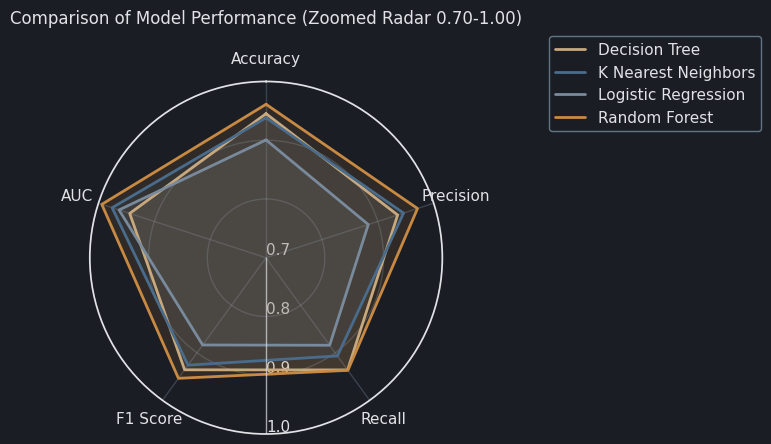

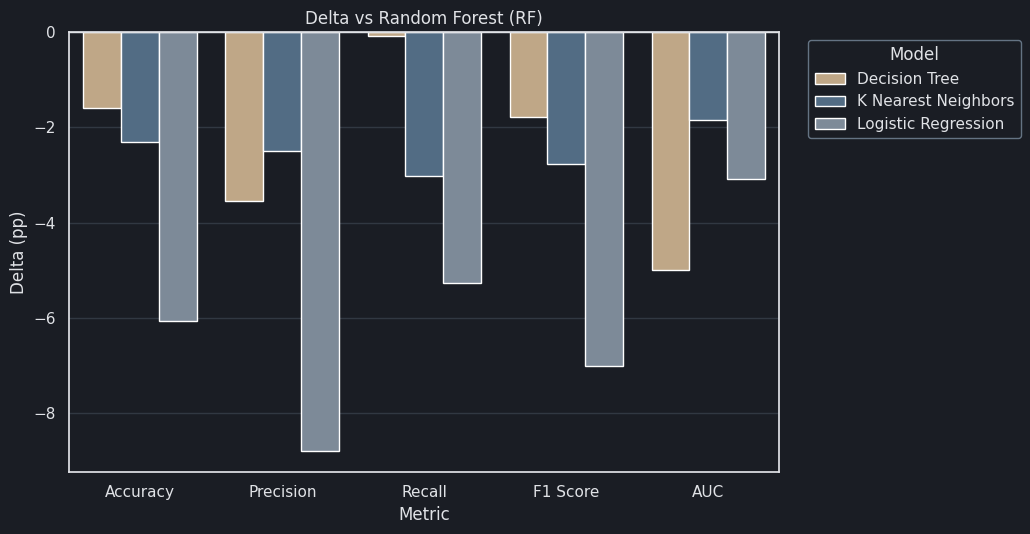

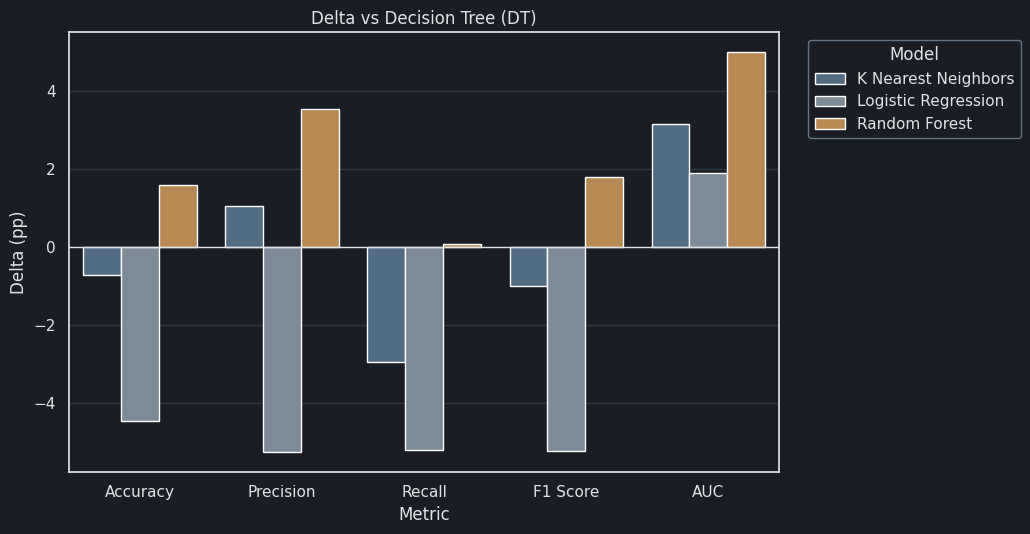

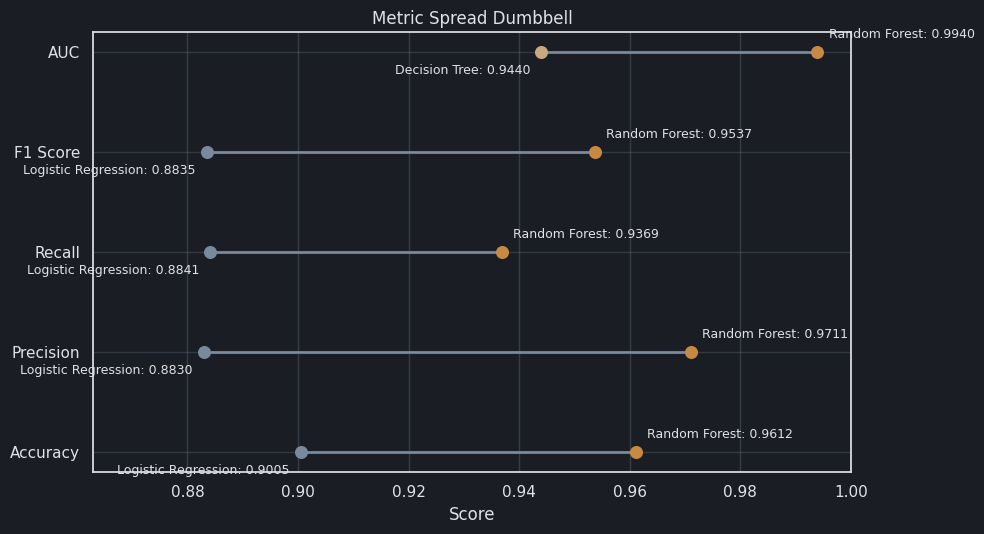

In [39]:
# Additional comparison plots: zoomed radar, deltas vs RF/DT, and a dumbbell chart.
first_tryout_pivot = (
    df_long
    .pivot_table(index='Model', columns='Metric', values='Score', aggfunc='mean')
    .reindex(columns=RADAR_METRICS)
)

plot_zoomed_radar_from_pivot(
    first_tryout_pivot,
    'Comparison of Model Performance (Zoomed Radar 0.70-1.00)',
    rmin=0.70,
    rmax=1.00,
)

plot_delta_vs_reference(
    first_tryout_pivot,
    reference_label='Random Forest',
    title='Delta vs Random Forest (RF)',
)

plot_delta_vs_reference(
    first_tryout_pivot,
    reference_label='Decision Tree',
    title='Delta vs Decision Tree (DT)',
)

plot_metric_dumbbell(
    first_tryout_pivot,
    title='Metric Spread Dumbbell',
)


##### **Interpretation of Results**

Validation results show a clear ranking:

- **Random Forest** performs best overall (`Accuracy 0.9629`, `F1 0.9557`, `AUC 0.9944`).
- **Decision Tree** is second, with strong and balanced metrics (`Accuracy 0.9469`, `F1 0.9381`).
- **KNN** remains competitive but with lower recall than tree-based models.
- **Logistic Regression** is the weakest baseline in this feature space.

Overall, non-linear tree-based models capture the satisfaction patterns more effectively than the linear baseline.


---


## **Hyperparameter Tuning**

---


After baseline validation, hyperparameter tuning is applied to the three strongest candidates: **Decision Tree**, **Random Forest**, and **KNN**.

In [40]:
# Define a stratified cross-validation strategy for all tuning steps.
stratified_cv = StratifiedKFold(n_splits=4, shuffle=True, random_state=RANDOM_STATE)


We use a single tuning strategy (`RandomizedSearchCV`) for each shortlisted model.

This keeps the workflow clear, computationally efficient, and methodologically consistent. Each search uses stratified cross-validation (`StratifiedKFold`) with `accuracy` as the primary selection metric.

---


##### **Decision Tree**


Parameter space tuned for **Decision Tree**:

- `max_depth`: limits tree complexity.
- `min_samples_split`: minimum samples required to split an internal node.
- `min_samples_leaf`: minimum samples required in each leaf node.


Fitting 4 folds for each of 20 candidates, totalling 80 fits
Best parameters: {'model__min_samples_split': 4, 'model__min_samples_leaf': 4, 'model__max_depth': 20}
Best CV accuracy: 0.9489


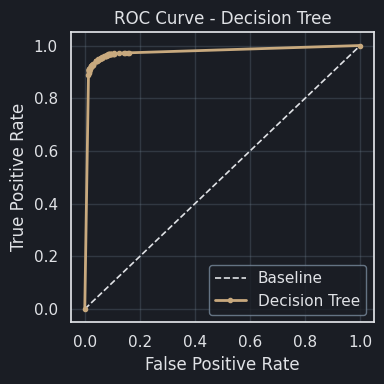

,Model,Accuracy,Precision,Recall,F1 Score,AUC
0,Decision Tree,0.952172,0.957933,0.92872,0.943101,0.974548


In [41]:
# Define the hyperparameter search space.
max_depth_dt = [int(x) for x in np.linspace(10, 40, num=4)]
max_depth_dt.append(None)
min_samples_split_dt = [int(x) for x in np.linspace(2, 10, num=5)]
min_samples_leaf_dt = [int(x) for x in np.linspace(1, 5, num=5)]

# Build the randomized-search parameter grid.
random_grid_DT = {
    'model__max_depth': max_depth_dt,
    'model__min_samples_split': min_samples_split_dt,
    'model__min_samples_leaf': min_samples_leaf_dt
}

# Build a full pipeline so preprocessing runs within each CV fold.
DT_search_pipeline = Pipeline(steps=[
    ('transformation', transformation),
    ('model', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

# Configure `RandomizedSearchCV`.
DT_randcv = RandomizedSearchCV(
    DT_search_pipeline,
    random_grid_DT,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1,
    n_iter=20,
    random_state=RANDOM_STATE,
    cv=stratified_cv,
    refit=True
)

# Fit randomized search on the training-core split only.
DT_randcv.fit(training_raw, training_check)

# Retrieve the best estimator and hyperparameters.
rand_bestparams_DT = DT_randcv.best_params_
DT_bestparams = DT_randcv.best_estimator_
print(f"Best parameters: {rand_bestparams_DT}")
print(f"Best CV accuracy: {DT_randcv.best_score_:.4f}")

# Evaluate the tuned model on the validation set.
prediction_DT = DT_bestparams.predict(validation_raw)
score_DT = DT_bestparams.predict_proba(validation_raw)[:, 1]

# Compute performance metrics.
accuracy_DT = accuracy_score(validation_test_check, prediction_DT)
precision_DT = precision_score(validation_test_check, prediction_DT)
recall_DT = recall_score(validation_test_check, prediction_DT)
f1_DT = f1_score(validation_test_check, prediction_DT)

# Compute ROC curve coordinates and ROC-AUC.
fpr, tpr, thresholds = roc_curve(validation_test_check, score_DT)
auc_DT = roc_auc_score(validation_test_check, score_DT)

# Plot the ROC curve.
plot_roc_custom(fpr, tpr, 'Decision Tree')

# Store the results in a DataFrame.
results_dt_val = pd.DataFrame(data=[['Decision Tree', accuracy_DT, precision_DT, recall_DT, f1_DT, auc_DT]],
                        columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC'])
results_dt_val


In [42]:
cm = confusion_matrix(validation_test_check, prediction_DT)
cm = pd.DataFrame(cm, index=['Actual Negative', 'Actual Positive'], columns=['Predicted Negative', 'Predicted Positive'])
cm


,Predicted Negative,Predicted Positive
Actual Negative,10633,333
Actual Positive,582,7583


In [43]:
# Report the best `RandomizedSearchCV` configuration.
DT_bestparams = DT_randcv.best_estimator_
print(f"RandomizedSearchCV best parameters: {rand_bestparams_DT}")
print(f"RandomizedSearchCV best CV accuracy: {DT_randcv.best_score_:.4f}")


RandomizedSearchCV best parameters: {'model__min_samples_split': 4, 'model__min_samples_leaf': 4, 'model__max_depth': 20}
RandomizedSearchCV best CV accuracy: 0.9489


In [44]:
cm = confusion_matrix(validation_test_check, prediction_DT)
cm = pd.DataFrame(cm, index=['Actual Negative', 'Actual Positive'], columns=['Predicted Negative', 'Predicted Positive'])
cm


,Predicted Negative,Predicted Positive
Actual Negative,10633,333
Actual Positive,582,7583


---


##### **Random Forest**


Parameter space tuned for **Random Forest**:

- `n_estimators`: number of trees in the ensemble.
- `max_depth`: maximum depth of each tree.
- `min_samples_split`: minimum samples required to split an internal node.
- `min_samples_leaf`: minimum samples required in each leaf node.


Fitting 4 folds for each of 30 candidates, totalling 120 fits
Best parameters: {'model__n_estimators': 200, 'model__min_samples_split': 2, 'model__min_samples_leaf': 1, 'model__max_depth': None}
Best CV accuracy: 0.9622


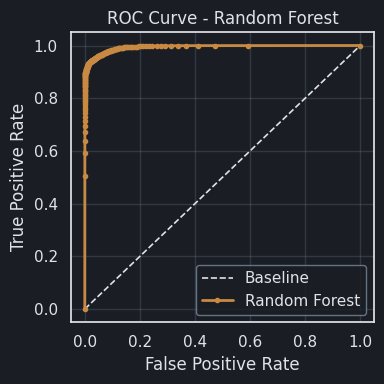

,Model,Accuracy,Precision,Recall,F1 Score,AUC
0,Random Forest,0.962103,0.971005,0.939253,0.954865,0.994189


In [45]:
# Define the hyperparameter search space.
n_estimators = [int(x) for x in np.linspace(start=100, stop=200, num=7)]
max_depth = [None, 10, 20, 30]
min_samples_split = list(range(2, 4))
min_samples_leaf = list(range(1, 3))

# Build the randomized-search parameter grid.
random_grid_RF = {
    'model__n_estimators': n_estimators,
    'model__max_depth': max_depth,
    'model__min_samples_split': min_samples_split,
    'model__min_samples_leaf': min_samples_leaf
}

# Build a full pipeline so preprocessing runs within each CV fold.
RF_search_pipeline = Pipeline(steps=[
    ('transformation', transformation),
    ('model', RandomForestClassifier(n_jobs=-1, random_state=RANDOM_STATE))
])

RF_randcv = RandomizedSearchCV(
    RF_search_pipeline,
    scoring='accuracy',
    param_distributions=random_grid_RF,
    n_iter=30,
    cv=stratified_cv,
    verbose=1,
    random_state=RANDOM_STATE,
    n_jobs=-1,
    refit=True
)

# Fit randomized search on the training-core split only.
RF_randcv.fit(training_raw, training_check)

# Retrieve the best estimator and hyperparameters.
rand_bestparams_RF = RF_randcv.best_params_
RF_bestparams = RF_randcv.best_estimator_
print(f"Best parameters: {rand_bestparams_RF}")
print(f"Best CV accuracy: {RF_randcv.best_score_:.4f}")

# Evaluate the tuned model on the validation set.
prediction_RF = RF_bestparams.predict(validation_raw)
score_RF = RF_bestparams.predict_proba(validation_raw)[:, 1]

# Compute performance metrics.
accuracy_RF = accuracy_score(validation_test_check, prediction_RF)
precision_RF = precision_score(validation_test_check, prediction_RF)
recall_RF = recall_score(validation_test_check, prediction_RF)
f1_RF = f1_score(validation_test_check, prediction_RF)

# Compute ROC curve coordinates and ROC-AUC.
fpr, tpr, thresholds = roc_curve(validation_test_check, score_RF)
auc_RF = roc_auc_score(validation_test_check, score_RF)

# Plot the ROC curve.
plot_roc_custom(fpr, tpr, 'Random Forest')

# Store the results in a DataFrame.
results_rf_val = pd.DataFrame(data=[['Random Forest', accuracy_RF, precision_RF, recall_RF, f1_RF, auc_RF]],
                        columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC'])
results_rf_val


In [46]:
cm = confusion_matrix(validation_test_check, prediction_RF)
cm = pd.DataFrame(cm, index=['Actual Negative', 'Actual Positive'], columns=['Predicted Negative', 'Predicted Positive'])
cm


,Predicted Negative,Predicted Positive
Actual Negative,10737,229
Actual Positive,496,7669


In [47]:
# Report the best `RandomizedSearchCV` configuration.
RF_bestparams = RF_randcv.best_estimator_
print(f"RandomizedSearchCV best parameters: {rand_bestparams_RF}")
print(f"RandomizedSearchCV best CV accuracy: {RF_randcv.best_score_:.4f}")


RandomizedSearchCV best parameters: {'model__n_estimators': 200, 'model__min_samples_split': 2, 'model__min_samples_leaf': 1, 'model__max_depth': None}
RandomizedSearchCV best CV accuracy: 0.9622


In [48]:
cm = confusion_matrix(validation_test_check, prediction_RF)
cm = pd.DataFrame(cm, index=['Actual Negative', 'Actual Positive'], columns=['Predicted Negative', 'Predicted Positive'])
cm


,Predicted Negative,Predicted Positive
Actual Negative,10737,229
Actual Positive,496,7669


---


##### **KNN**


Parameter space tuned for **KNN**:

- `n_neighbors`: number of neighbors used for prediction.
- `weights`: weighting scheme for neighbor contributions (`distance` in the selected grid).
- `metric`: distance metric used to compute neighbor similarity.


Fitting 4 folds for each of 6 candidates, totalling 24 fits
Best parameters: {'model__weights': 'distance', 'model__n_neighbors': 13, 'model__metric': 'manhattan'}
Best CV accuracy: 0.9422


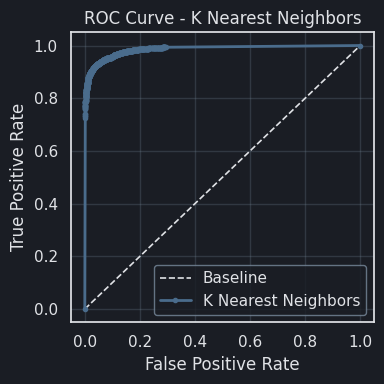

,Model,Accuracy,Precision,Recall,F1 Score,AUC
0,K Nearest Neighbors,0.945063,0.951052,0.918555,0.934521,0.985375


In [49]:
# Define the hyperparameter search space.
random_grid_KNN = {
    'model__n_neighbors': list(range(7, 21, 2)),
    'model__weights': ['distance'],
    'model__metric': ['manhattan', 'euclidean']
}

# Build a full pipeline so preprocessing runs within each CV fold.
KNN_search_pipeline = Pipeline(steps=[
    ('transformation', transformation),
    ('model', KNeighborsClassifier(n_jobs=-1))
])

# Configure `RandomizedSearchCV`.
KNN_randcv = RandomizedSearchCV(
    KNN_search_pipeline,
    random_grid_KNN,
    scoring='accuracy',
    n_jobs=-1,
    verbose=1,
    n_iter=6,
    cv=stratified_cv,
    random_state=RANDOM_STATE,
    refit=True
)

# Fit randomized search on the training-core split only.
KNN_randcv.fit(training_raw, training_check)

# Retrieve the best estimator and hyperparameters.
rand_bestparams_KNN = KNN_randcv.best_params_
KNN_bestparams = KNN_randcv.best_estimator_
print(f"Best parameters: {rand_bestparams_KNN}")
print(f"Best CV accuracy: {KNN_randcv.best_score_:.4f}")

# Generate validation predictions and probabilities.
prediction_KNN = KNN_bestparams.predict(validation_raw)
score_KNN = KNN_bestparams.predict_proba(validation_raw)[:, 1]

# Compute performance metrics.
accuracy_KNN = accuracy_score(validation_test_check, prediction_KNN)
precision_KNN = precision_score(validation_test_check, prediction_KNN)
recall_KNN = recall_score(validation_test_check, prediction_KNN)
f1_KNN = f1_score(validation_test_check, prediction_KNN)

# Compute ROC curve coordinates and ROC-AUC.
fpr, tpr, thresholds = roc_curve(validation_test_check, score_KNN)
auc_KNN = roc_auc_score(validation_test_check, score_KNN)

# Plot the ROC curve.
plot_roc_custom(fpr, tpr, 'K Nearest Neighbors')

# Store the results in a DataFrame.
results_knn_val = pd.DataFrame(data=[['K Nearest Neighbors', accuracy_KNN, precision_KNN, recall_KNN, f1_KNN, auc_KNN]],
                        columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC'])
results_knn_val


In [50]:
cm = confusion_matrix(validation_test_check, prediction_KNN)
cm = pd.DataFrame(cm, index=['Actual Negative', 'Actual Positive'], columns=['Predicted Negative', 'Predicted Positive'])
cm


,Predicted Negative,Predicted Positive
Actual Negative,10580,386
Actual Positive,665,7500


In [51]:
# Report the best `RandomizedSearchCV` configuration.
KNN_bestparams = KNN_randcv.best_estimator_
print(f"RandomizedSearchCV best parameters: {rand_bestparams_KNN}")
print(f"RandomizedSearchCV best CV accuracy: {KNN_randcv.best_score_:.4f}")


RandomizedSearchCV best parameters: {'model__weights': 'distance', 'model__n_neighbors': 13, 'model__metric': 'manhattan'}
RandomizedSearchCV best CV accuracy: 0.9422


In [52]:
cm = confusion_matrix(validation_test_check, prediction_KNN)
cm = pd.DataFrame(cm, index=['Actual Negative', 'Actual Positive'], columns=['Predicted Negative', 'Predicted Positive'])
cm


,Predicted Negative,Predicted Positive
Actual Negative,10580,386
Actual Positive,665,7500


---


##### **Interpretation of Results**

Hyperparameter tuning improved validation performance, with gains varying by model:

- **Decision Tree** shows a meaningful improvement, especially in AUC and overall balance.
- **KNN** also improves across all key metrics, with better recall/F1 than baseline KNN.
- **Random Forest** remains the best model and changes only marginally (already near its local optimum).

The tuned results confirm Random Forest as the strongest candidate for final testing.


---


## **Testing**

---


This section evaluates tuned models on the held-out test set to estimate real generalization performance.

##### **Decision Tree**


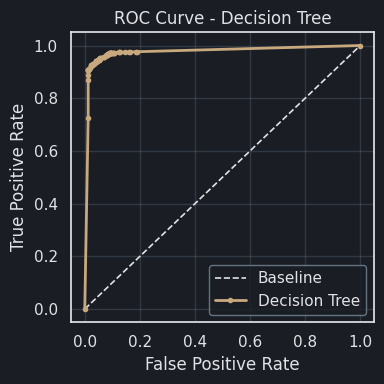

,Model,Accuracy,Precision,Recall,F1 Score,AUC
0,Decision Tree,0.952538,0.956058,0.931609,0.943675,0.975704


In [53]:
# Refit on the full development set (training core + validation), then evaluate on the test set.
DT_bestparams.fit(train, train_check)
test_prediction_DT = DT_bestparams.predict(test)
score_DT = DT_bestparams.predict_proba(test)[:, 1]

# Compute performance metrics.
accuracy_DT = accuracy_score(test_check, test_prediction_DT)
precision_DT = precision_score(test_check, test_prediction_DT)
recall_DT = recall_score(test_check, test_prediction_DT)
f1_DT = f1_score(test_check, test_prediction_DT)

# Compute ROC curve coordinates and ROC-AUC.
fpr, tpr, thresholds = roc_curve(test_check, score_DT)
auc_DT = roc_auc_score(test_check, score_DT)

# Plot the ROC curve.
plot_roc_custom(fpr, tpr, 'Decision Tree')

# Store the results in a DataFrame.
results_dt_test = pd.DataFrame(data=[['Decision Tree', accuracy_DT, precision_DT, recall_DT, f1_DT, auc_DT]],
                        columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC'])
results_dt_test


In [54]:
cm = confusion_matrix(test_check, test_prediction_DT)
cm = pd.DataFrame(cm, index=['Actual Negative', 'Actual Positive'], columns=['Predicted Negative', 'Predicted Positive'])
cm


,Predicted Negative,Predicted Positive
Actual Negative,13271,437
Actual Positive,698,9508


---


##### **Random Forest**


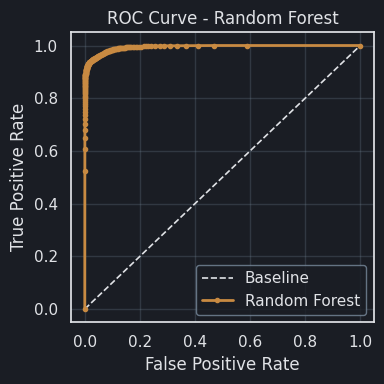

,Model,Accuracy,Precision,Recall,F1 Score,AUC
0,Random Forest,0.962407,0.971718,0.939251,0.955209,0.994354


In [55]:
# Refit on the full development set (training core + validation), then evaluate on the test set.
RF_bestparams.fit(train, train_check)
prediction_RF = RF_bestparams.predict(test)
score_RF = RF_bestparams.predict_proba(test)[:, 1]

# Compute performance metrics.
accuracy_RF = accuracy_score(test_check, prediction_RF)
precision_RF = precision_score(test_check, prediction_RF)
recall_RF = recall_score(test_check, prediction_RF)
f1_RF = f1_score(test_check, prediction_RF)

# Compute ROC curve coordinates and ROC-AUC.
fpr, tpr, thresholds = roc_curve(test_check, score_RF)
auc_RF = roc_auc_score(test_check, score_RF)

# Plot the ROC curve.
plot_roc_custom(fpr, tpr, 'Random Forest')

# Store the results in a DataFrame.
results_rf_test = pd.DataFrame(data=[['Random Forest', accuracy_RF, precision_RF, recall_RF, f1_RF, auc_RF]],
                        columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC'])
results_rf_test


In [56]:
cm = confusion_matrix(test_check, prediction_RF)
cm = pd.DataFrame(cm, index=['Actual Negative', 'Actual Positive'], columns=['Predicted Negative', 'Predicted Positive'])
cm


,Predicted Negative,Predicted Positive
Actual Negative,13429,279
Actual Positive,620,9586


---


##### **KNN**


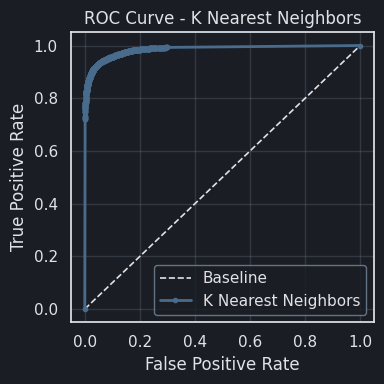

,Model,Accuracy,Precision,Recall,F1 Score,AUC
0,K Nearest Neighbors,0.943548,0.946912,0.919263,0.932883,0.984878


In [57]:
# Refit on the full development set (training core + validation), then evaluate on the test set.
KNN_bestparams.fit(train, train_check)
prediction_KNN = KNN_bestparams.predict(test)
score_KNN = KNN_bestparams.predict_proba(test)[:, 1]

# Compute performance metrics.
accuracy_KNN = accuracy_score(test_check, prediction_KNN)
precision_KNN = precision_score(test_check, prediction_KNN)
recall_KNN = recall_score(test_check, prediction_KNN)
f1_KNN = f1_score(test_check, prediction_KNN)

# Compute ROC curve coordinates and ROC-AUC.
fpr, tpr, thresholds = roc_curve(test_check, score_KNN)
auc_KNN = roc_auc_score(test_check, score_KNN)

# Plot the ROC curve.
plot_roc_custom(fpr, tpr, 'K Nearest Neighbors')

# Store the results in a DataFrame.
results_knn_test = pd.DataFrame(data=[['K Nearest Neighbors', accuracy_KNN, precision_KNN, recall_KNN, f1_KNN, auc_KNN]],
                        columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC'])
results_knn_test


In [58]:
cm = confusion_matrix(test_check, prediction_KNN)
cm = pd.DataFrame(cm, index=['Actual Negative', 'Actual Positive'], columns=['Predicted Negative', 'Predicted Positive'])
cm


,Predicted Negative,Predicted Positive
Actual Negative,13182,526
Actual Positive,824,9382


---


In [59]:
test_results = pd.concat([results_dt_test, results_rf_test, results_knn_test], ignore_index=True)
test_results = test_results.sort_values(by='Accuracy', ascending=False)
test_results


,Model,Accuracy,Precision,Recall,F1 Score,AUC
1,Random Forest,0.962407,0.971718,0.939251,0.955209,0.994354
0,Decision Tree,0.952538,0.956058,0.931609,0.943675,0.975704
2,K Nearest Neighbors,0.943548,0.946912,0.919263,0.932883,0.984878


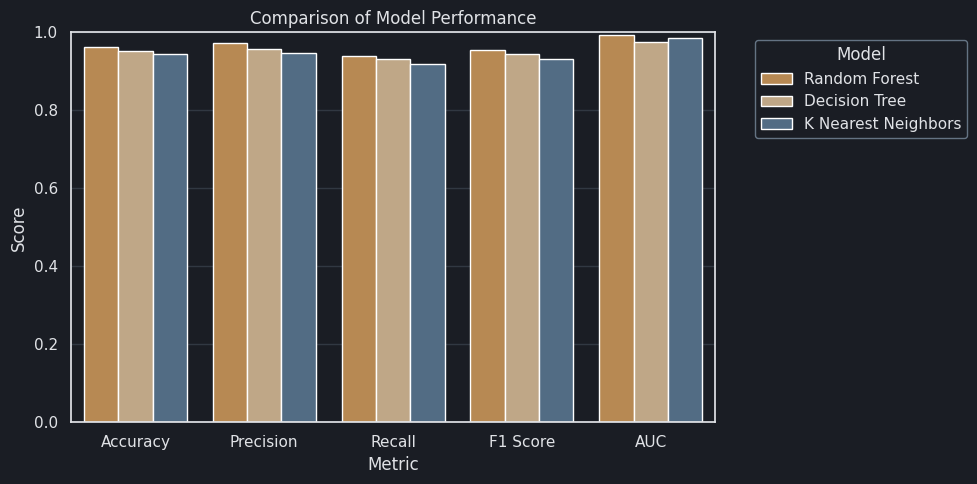

In [60]:
# Assemble model metrics for visualization.
test_metrics_dictionary = {
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC'],
    'Random Forest': test_results[test_results['Model'] == 'Random Forest'].values.tolist()[0][1:],
    'Decision Tree': test_results[test_results['Model'] == 'Decision Tree'].values.tolist()[0][1:],
    'K Nearest Neighbors': test_results[test_results['Model'] == 'K Nearest Neighbors'].values.tolist()[0][1:]
}
test_metrics_df = pd.DataFrame(test_metrics_dictionary)

# Reshape the DataFrame to long format for Seaborn.
test_df_long = pd.melt(test_metrics_df, id_vars=['Metric'], value_vars=['Random Forest', 'Decision Tree', 'K Nearest Neighbors'],
                  var_name='Model', value_name='Score')

# Plot the model-metric comparison.
model_order = ['Random Forest', 'Decision Tree', 'K Nearest Neighbors']
plt.figure(figsize=(10, 5))
ax = sns.barplot(
    x='Metric',
    y='Score',
    hue='Model',
    hue_order=model_order,
    data=test_df_long,
    palette={m: MODEL_PALETTE[m] for m in model_order}
)

# Move the legend outside the plot to avoid overlap.
legend = plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left')
style_legend(legend)

plt.title('Comparison of Model Performance')
plt.ylabel('Score')
plt.ylim(0, 1)
style_axes(ax)

# Render the plot.
plt.tight_layout()
plt.show()


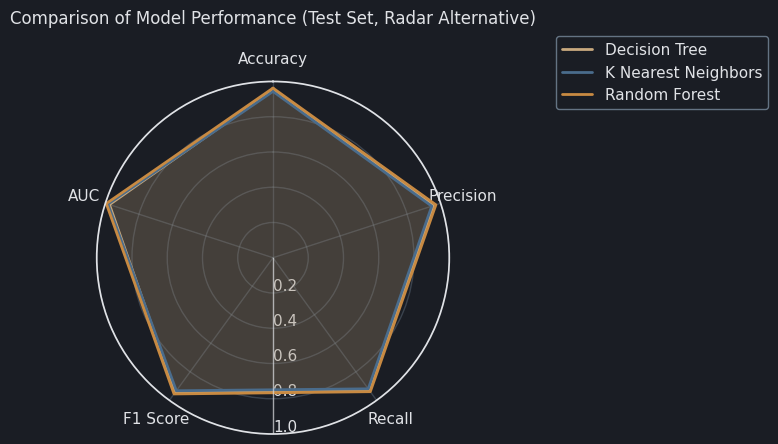

In [61]:
# Plot a radar chart for tuned-model test-set performance.
plot_model_radar(
    test_df_long,
    'Comparison of Model Performance (Test Set, Radar Alternative)',
    model_col='Model',
    metric_col='Metric',
    score_col='Score'
)


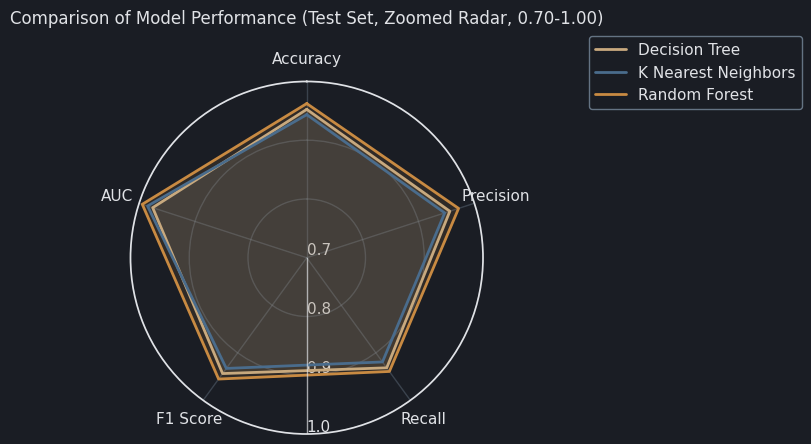

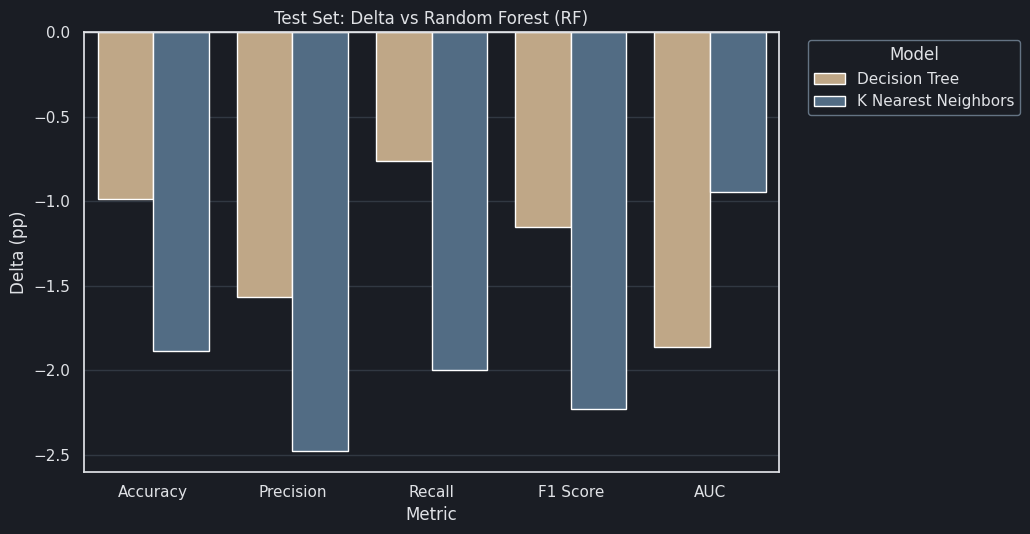

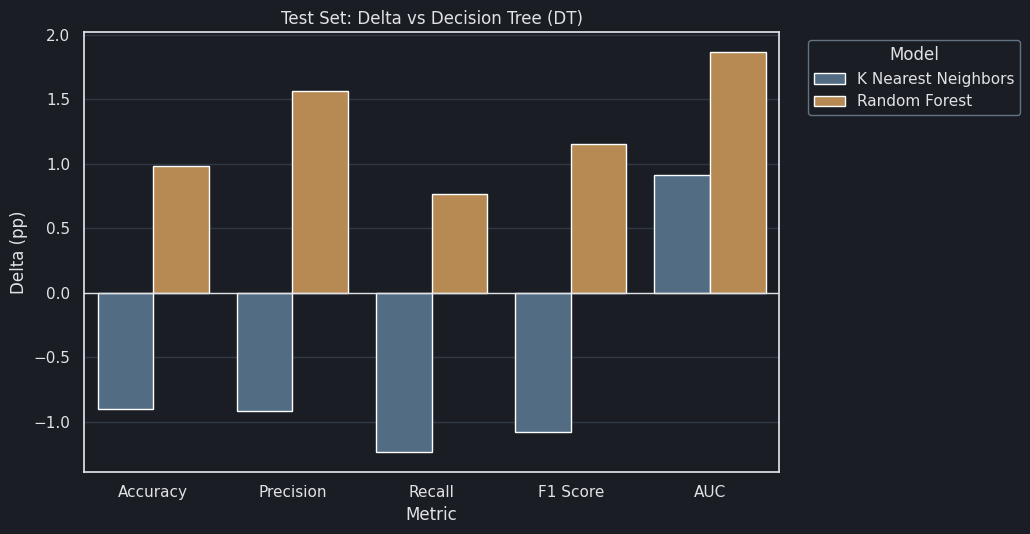

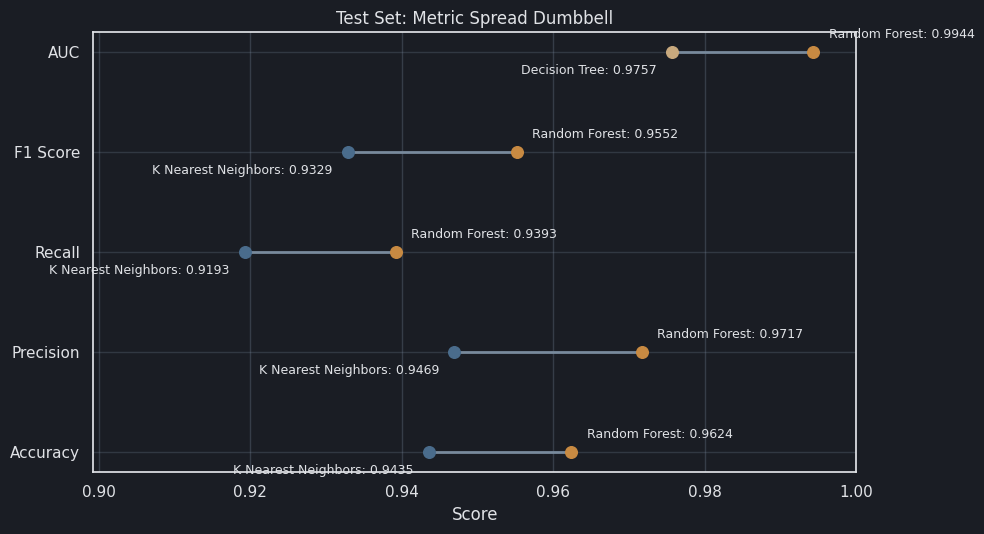

In [62]:
# Additional tuned test-set plots: zoomed radar, deltas vs RF/DT, and a dumbbell chart.
test_tryout_pivot = (
    test_df_long
    .pivot_table(index='Model', columns='Metric', values='Score', aggfunc='mean')
    .reindex(columns=RADAR_METRICS)
)

plot_zoomed_radar_from_pivot(
    test_tryout_pivot,
    'Comparison of Model Performance (Test Set, Zoomed Radar, 0.70-1.00)',
    rmin=0.70,
    rmax=1.00,
)

plot_delta_vs_reference(
    test_tryout_pivot,
    reference_label='Random Forest',
    title='Test Set: Delta vs Random Forest (RF)',
)

plot_delta_vs_reference(
    test_tryout_pivot,
    reference_label='Decision Tree',
    title='Test Set: Delta vs Decision Tree (DT)',
)

plot_metric_dumbbell(
    test_tryout_pivot,
    title='Test Set: Metric Spread Dumbbell',
)


##### **Interpretation of Results**

On the test set, all tuned models remain strong, and the ranking is consistent with validation:

- **Random Forest** is best overall (`Accuracy 0.9651`, `F1 0.9584`, `AUC 0.9948`).
- **Decision Tree** is a close second with balanced performance.
- **KNN** improves after tuning but remains behind the tree-based models.

These results support using Random Forest as the primary rating-enabled model.


---




## **Alternative Pipeline Without Ratings**

---


Before interpreting the no-rating pipeline, we need to state a key business limitation: service ratings in this notebook are collected **after** the trip, and customers cannot be forced to submit them.

As a result, rating-based features are informative but not consistently available for every customer. If the company relies only on rating-dependent models, coverage becomes limited whenever feedback is missing.

For this reason, the analysis should be treated as two complementary model tracks, based on feedback availability:
- **Rating service model (with ratings):** used when feedback is available, to support post-trip recovery, root-cause diagnosis, and campaign targeting.
- **No Rating service model (without ratings):** used when ratings are missing, to support proactive targeting with lower expected metrics but broader operational applicability.

This separation better matches the company's needs and keeps recommendations actionable in real operations, even when customer feedback collection is incomplete.

Following the rating-availability limitation, this parallel workflow uses only features that can be collected without post-trip review scores:

- `Age`
- `Arrival Delay in Minutes`
- `Ticket Class`
- `Loyalty`
- `Gender`
- `Distance`
- `Work or Leisure`
- `Departure Delay in Minutes`


In [63]:
# Define features available without customer-review ratings.
no_rating_columns = [
    'Age',
    'Arrival Delay in Minutes',
    'Ticket Class',
    'Loyalty',
    'Gender',
    'Travel Month',
    'Travel Hour',
    'Distance',
    'Work or Leisure',
    'Departure Delay in Minutes'
]

# Build a dedicated no-rating dataset directly from source features.
no_rating_df = trains_df.copy()

if 'Travel Month' not in no_rating_df.columns or 'Travel Hour' not in no_rating_df.columns:
    if 'Date and Time' not in no_rating_df.columns:
        raise KeyError("'Date and Time' is required to derive 'Travel Month' and 'Travel Hour'.")

    no_rating_df['Date and Time'] = pd.to_datetime(no_rating_df['Date and Time'], errors='coerce')
    no_rating_df['Travel Month'] = no_rating_df['Date and Time'].dt.month
    no_rating_df['Travel Hour'] = no_rating_df['Date and Time'].dt.hour

missing_no_rating_columns = [col for col in no_rating_columns if col not in no_rating_df.columns]
if missing_no_rating_columns:
    raise KeyError(f"Missing no-rating columns: {missing_no_rating_columns}")

no_rating_df = no_rating_df.dropna(subset=['Satisfied']).copy()

x_no_rating = no_rating_df[no_rating_columns].copy()
y_no_rating = no_rating_df['Satisfied'].map({'N': 0, 'Y': 1})

# Apply the same split strategy used in the main pipeline.
nr_train, nr_test, nr_train_check, nr_test_check = train_test_split(
    x_no_rating, y_no_rating, test_size=0.2, random_state=RANDOM_STATE, stratify=y_no_rating
)

nr_training_raw, nr_validation_raw, nr_training_check, nr_validation_check = train_test_split(
    nr_train, nr_train_check, test_size=0.2, random_state=RANDOM_STATE, stratify=nr_train_check
)

nr_numerical_columns = x_no_rating.select_dtypes(include=['int64', 'float64']).columns.tolist()
nr_categorical_columns = x_no_rating.select_dtypes(include=['object']).columns.tolist()

nr_transformation = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[('arrival_delay_imputer', ArrivalDelayLinearRegImputer()), ('scaler', StandardScaler())]), nr_numerical_columns),
        ('cat', Pipeline(steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))]), nr_categorical_columns)
    ]
)

nr_model_pipeline = Pipeline(steps=[('transformation', nr_transformation)])

nr_training = nr_model_pipeline.fit_transform(nr_training_raw)
nr_validation = nr_model_pipeline.transform(nr_validation_raw)
nr_test_encoded = nr_model_pipeline.transform(nr_test)


##### **No-Rating Validation (Baseline Models)**


In [64]:
# Evaluate baseline validation performance using only no-rating features.
nr_baseline_models = {
    'Decision Tree': DecisionTreeClassifier(random_state=RANDOM_STATE),
    'Random Forest': RandomForestClassifier(n_jobs=-1, random_state=RANDOM_STATE),
    'K Nearest Neighbors': KNeighborsClassifier(n_jobs=-1)
}

nr_validation_rows = []
for model_name, model in nr_baseline_models.items():
    model.fit(nr_training, nr_training_check)
    preds = model.predict(nr_validation)
    probs = model.predict_proba(nr_validation)[:, 1]

    nr_validation_rows.append({
        'Model': model_name,
        'Accuracy': accuracy_score(nr_validation_check, preds),
        'Precision': precision_score(nr_validation_check, preds),
        'Recall': recall_score(nr_validation_check, preds),
        'F1 Score': f1_score(nr_validation_check, preds),
        'AUC': roc_auc_score(nr_validation_check, probs)
    })

no_rating_validation_results = pd.DataFrame(nr_validation_rows).sort_values(by='Accuracy', ascending=False)
no_rating_validation_results


,Model,Accuracy,Precision,Recall,F1 Score,AUC
2,K Nearest Neighbors,0.783179,0.737833,0.763135,0.750271,0.833209
1,Random Forest,0.777795,0.737846,0.743539,0.740682,0.844240
0,Decision Tree,0.726360,0.679271,0.679853,0.679562,0.722382


##### **No-Rating Hyperparameter Tuning**


In [65]:
nr_stratified_cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)

nr_tuning_configs = {
    'Decision Tree': {
        'estimator': DecisionTreeClassifier(random_state=RANDOM_STATE),
        'params': {
            'model__max_depth': [10, 20, 30, 40, None],
            'model__min_samples_split': [2, 4, 6, 8, 10],
            'model__min_samples_leaf': [1, 2, 3, 4, 5]
        },
        'n_iter': 10
    },
    'Random Forest': {
        'estimator': RandomForestClassifier(n_jobs=-1, random_state=RANDOM_STATE),
        'params': {
            'model__n_estimators': [100, 120, 140, 160, 180, 200],
            'model__max_depth': [10, 20, 30, None],
            'model__min_samples_split': [2, 3, 4],
            'model__min_samples_leaf': [1, 2, 3]
        },
        'n_iter': 12
    },
    'K Nearest Neighbors': {
        'estimator': KNeighborsClassifier(n_jobs=-1),
        'params': {
            'model__n_neighbors': list(range(7, 21, 2)),
            'model__weights': ['uniform', 'distance'],
            'model__metric': ['manhattan', 'euclidean']
        },
        'n_iter': 6
    }
}

nr_tuned_models = {}
nr_tuned_validation_rows = []
nr_tuned_params_rows = []

for model_name, cfg in nr_tuning_configs.items():
    search_pipeline = Pipeline(steps=[
        ('transformation', nr_transformation),
        ('model', cfg['estimator'])
    ])

    nr_search = RandomizedSearchCV(
        search_pipeline,
        param_distributions=cfg['params'],
        n_iter=cfg['n_iter'],
        scoring='accuracy',
        cv=nr_stratified_cv,
        n_jobs=-1,
        random_state=RANDOM_STATE,
        refit=True
    )

    nr_search.fit(nr_training_raw, nr_training_check)
    nr_tuned_models[model_name] = nr_search.best_estimator_

    preds = nr_search.best_estimator_.predict(nr_validation_raw)
    probs = nr_search.best_estimator_.predict_proba(nr_validation_raw)[:, 1]

    nr_tuned_validation_rows.append({
        'Model': model_name,
        'Accuracy': accuracy_score(nr_validation_check, preds),
        'Precision': precision_score(nr_validation_check, preds),
        'Recall': recall_score(nr_validation_check, preds),
        'F1 Score': f1_score(nr_validation_check, preds),
        'AUC': roc_auc_score(nr_validation_check, probs)
    })

    nr_tuned_params_rows.append({
        'Model': model_name,
        'Best Params': nr_search.best_params_,
        'Best CV Accuracy': nr_search.best_score_
    })

no_rating_tuned_validation_results = pd.DataFrame(nr_tuned_validation_rows).sort_values(by='Accuracy', ascending=False)
no_rating_tuned_best_params = pd.DataFrame(nr_tuned_params_rows).sort_values(by='Best CV Accuracy', ascending=False)

print('Tuned validation results (no-rating features):')
display(no_rating_tuned_validation_results)
print('Best parameters (no-rating features):')
no_rating_tuned_best_params


Tuned validation results (no-rating features):


,Model,Accuracy,Precision,Recall,F1 Score,AUC
1,Random Forest,0.808322,0.756442,0.812492,0.783466,0.875147
0,Decision Tree,0.807590,0.753563,0.816044,0.783560,0.871058
2,K Nearest Neighbors,0.800533,0.749055,0.800980,0.774148,0.860360


Best parameters (no-rating features):


,Model,Best Params,Best CV Accuracy
1,Random Forest,"{'model__n_estimators': 120, 'model__min_sampl...",0.807951
0,Decision Tree,"{'model__min_samples_split': 4, 'model__min_sa...",0.803115
2,K Nearest Neighbors,"{'model__weights': 'uniform', 'model__n_neighb...",0.798319


##### **No-Rating Testing (Tuned Models)**


In [66]:
# Evaluate tuned no-rating models on the held-out test set.
nr_tuned_test_rows = []

for model_name, tuned_model in nr_tuned_models.items():
    # Refit on the full no-rating development set (training core + validation).
    tuned_model.fit(nr_train, nr_train_check)

    preds = tuned_model.predict(nr_test)
    probs = tuned_model.predict_proba(nr_test)[:, 1]

    nr_tuned_test_rows.append({
        'Model': model_name,
        'Accuracy': accuracy_score(nr_test_check, preds),
        'Precision': precision_score(nr_test_check, preds),
        'Recall': recall_score(nr_test_check, preds),
        'F1 Score': f1_score(nr_test_check, preds),
        'AUC': roc_auc_score(nr_test_check, probs)
    })

no_rating_tuned_test_results = pd.DataFrame(nr_tuned_test_rows).sort_values(by='Accuracy', ascending=False)
no_rating_tuned_test_results


,Model,Accuracy,Precision,Recall,F1 Score,AUC
1,Random Forest,0.810153,0.756938,0.817754,0.786172,0.873118
0,Decision Tree,0.806933,0.754115,0.812561,0.782248,0.868955
2,K Nearest Neighbors,0.799992,0.748101,0.801097,0.773693,0.860435


##### **Comparison of Tuned No-Rating Models (Test Set)**


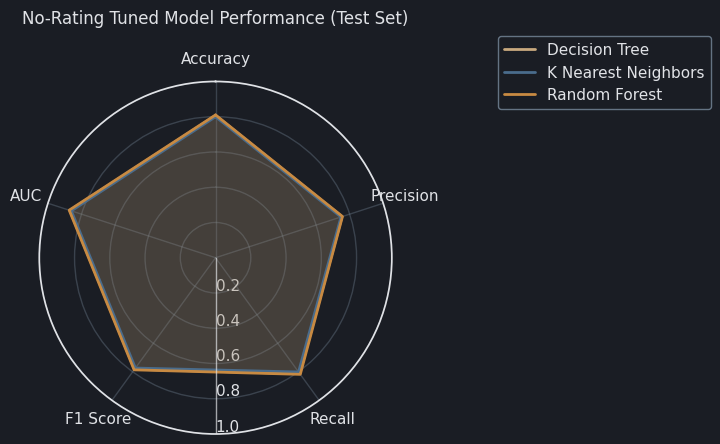

In [67]:
# Plot a radar chart for tuned no-rating models on the test set.
nr_tuned_plot_df = no_rating_tuned_test_results.melt(
    id_vars='Model',
    value_vars=['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC'],
    var_name='Metric',
    value_name='Score'
)

plot_model_radar(
    nr_tuned_plot_df,
    'No-Rating Tuned Model Performance (Test Set)',
    model_col='Model',
    metric_col='Metric',
    score_col='Score'
)


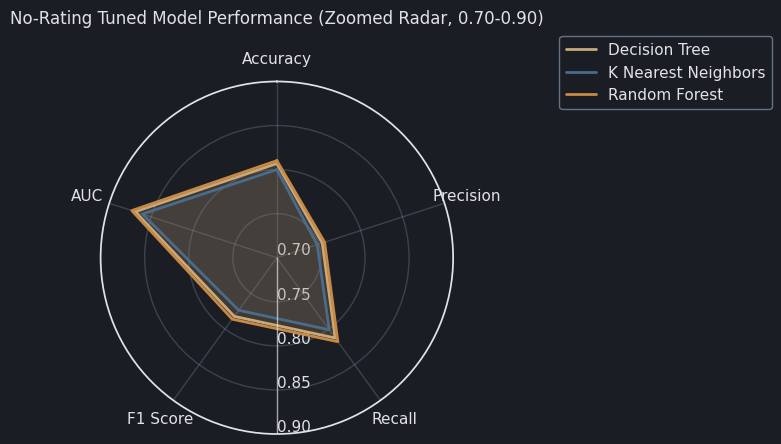

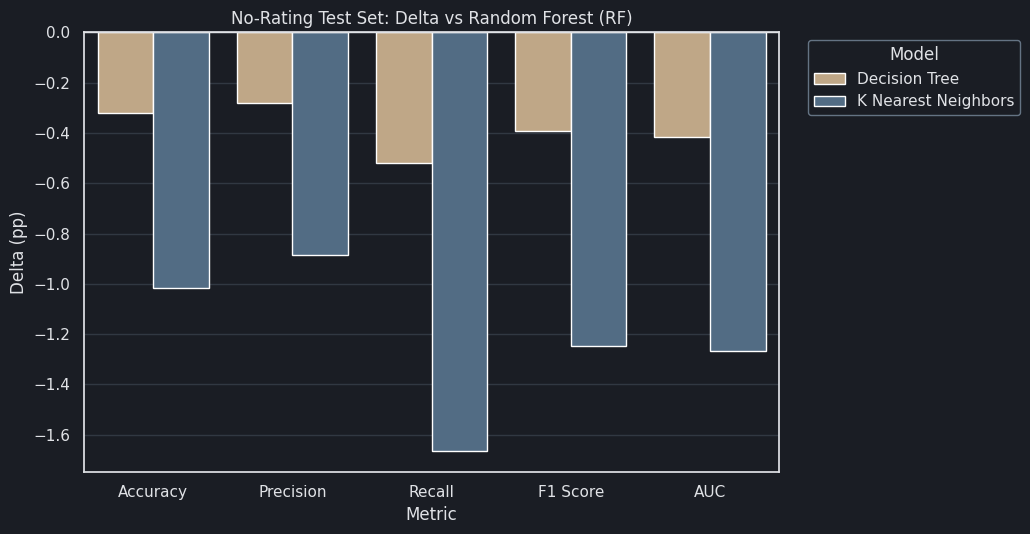

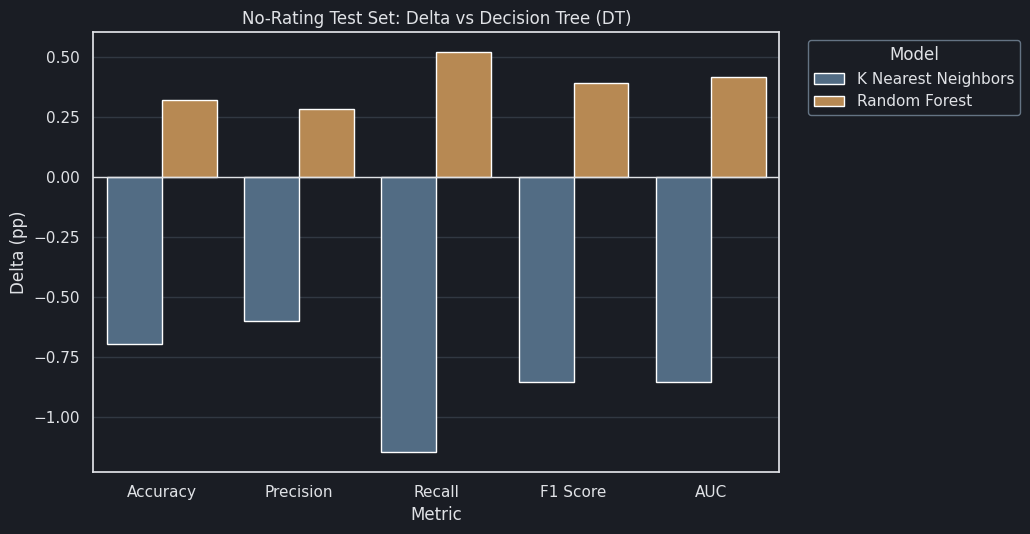

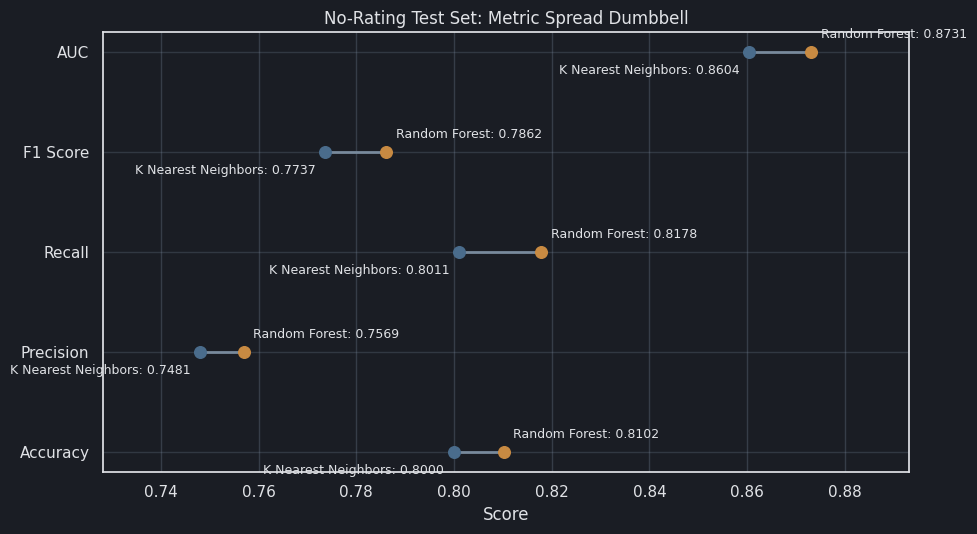

In [68]:
# Additional no-rating plots: zoomed radar, deltas vs RF/DT, and a dumbbell chart.
no_rating_tryout_pivot = (
    nr_tuned_plot_df
    .pivot_table(index='Model', columns='Metric', values='Score', aggfunc='mean')
    .reindex(columns=RADAR_METRICS)
)

plot_zoomed_radar_from_pivot(
    no_rating_tryout_pivot,
    'No-Rating Tuned Model Performance (Zoomed Radar, 0.70-0.90)',
    rmin=0.70,
    rmax=0.90,
)

plot_delta_vs_reference(
    no_rating_tryout_pivot,
    reference_label='Random Forest',
    title='No-Rating Test Set: Delta vs Random Forest (RF)',
)

plot_delta_vs_reference(
    no_rating_tryout_pivot,
    reference_label='Decision Tree',
    title='No-Rating Test Set: Delta vs Decision Tree (DT)',
)

plot_metric_dumbbell(
    no_rating_tryout_pivot,
    title='No-Rating Test Set: Metric Spread Dumbbell',
)


##### **Tuned Models With Ratings vs Without Ratings (Test Set)**


In [69]:
with_rating_tuned_test_results = test_results.copy()

comparison_models = ['Decision Tree', 'Random Forest', 'K Nearest Neighbors']
with_rating_comparison = with_rating_tuned_test_results[with_rating_tuned_test_results['Model'].isin(comparison_models)].copy()
with_rating_comparison['Feature Set'] = 'With Ratings'

without_rating_comparison = no_rating_tuned_test_results[no_rating_tuned_test_results['Model'].isin(comparison_models)].copy()
without_rating_comparison['Feature Set'] = 'Without Ratings'

with_without_comparison = pd.concat([with_rating_comparison, without_rating_comparison], ignore_index=True)

with_without_long = with_without_comparison.melt(
    id_vars=['Model', 'Feature Set'],
    value_vars=['Accuracy', 'Precision', 'Recall', 'F1 Score', 'AUC'],
    var_name='Metric',
    value_name='Score'
)

with_without_comparison.sort_values(by=['Model', 'Feature Set'])


,Model,Accuracy,Precision,Recall,F1 Score,AUC,Feature Set
1,Decision Tree,0.952538,0.956058,0.931609,0.943675,0.975704,With Ratings
4,Decision Tree,0.806933,0.754115,0.812561,0.782248,0.868955,Without Ratings
2,K Nearest Neighbors,0.943548,0.946912,0.919263,0.932883,0.984878,With Ratings
5,K Nearest Neighbors,0.799992,0.748101,0.801097,0.773693,0.860435,Without Ratings
0,Random Forest,0.962407,0.971718,0.939251,0.955209,0.994354,With Ratings
3,Random Forest,0.810153,0.756938,0.817754,0.786172,0.873118,Without Ratings


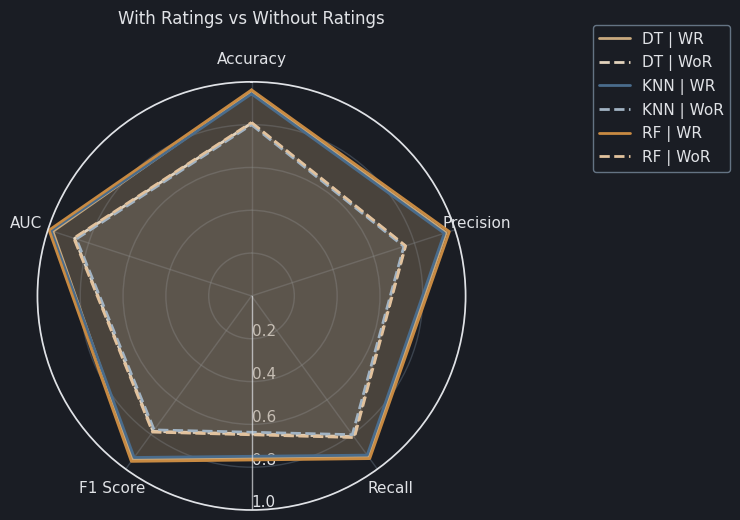

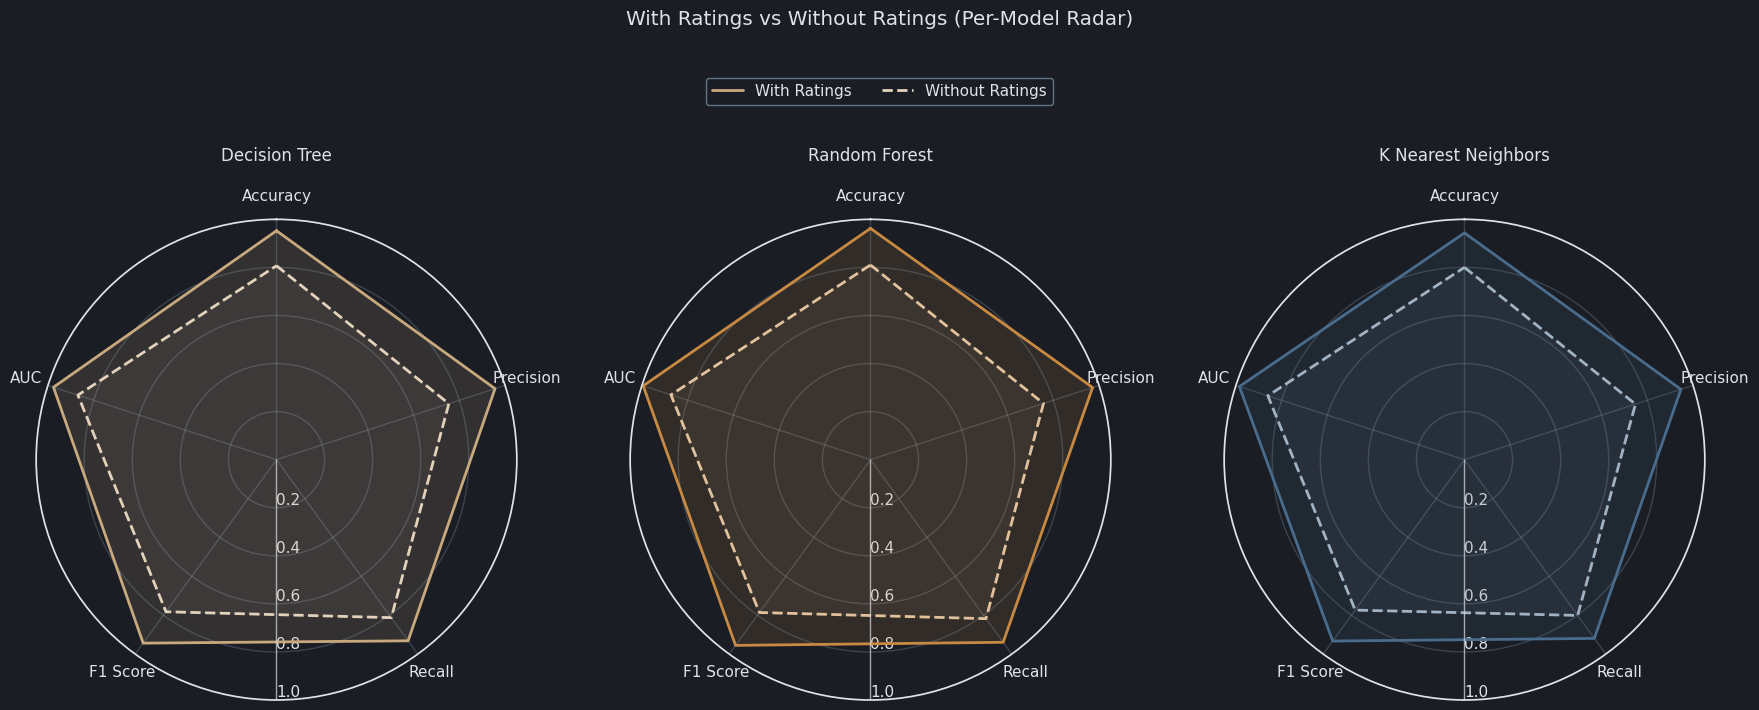

In [70]:
# Plot with-vs-without ratings radar charts using consistent model colors.
with_without_radar = with_without_long.copy()
with_without_pivot = with_without_radar.pivot_table(
    index=['Model', 'Feature Set'],
    columns='Metric',
    values='Score',
    aggfunc='mean'
).reindex(columns=RADAR_METRICS)

# Flatten multi-index labels for helper plots and delta analyses.
with_without_flat = with_without_pivot.copy()
with_without_flat.index = [f"{m} | {fs}" for m, fs in with_without_flat.index]

with_without_trace_palette = {}
with_without_trace_styles = {}
with_without_fill_alpha = {}
for model, feature_set in with_without_pivot.index:
    label = f"{model} | {feature_set}"
    base = MODEL_PALETTE.get(model, BASE_PALETTE[2])
    is_without = feature_set == 'Without Ratings'
    with_without_trace_palette[label] = _blend_with_white(base, blend=0.48) if is_without else base
    with_without_trace_styles[label] = '--' if is_without else '-'
    with_without_fill_alpha[label] = 0.06 if is_without else 0.14

# Build compact labels only for the big combined radar legend.
legend_model_short = {
    'Decision Tree': 'DT',
    'K Nearest Neighbors': 'KNN',
    'Random Forest': 'RF',
    'Logistic Regression': 'LR'
}
legend_feature_short = {'With Ratings': 'WR', 'Without Ratings': 'WoR'}

with_without_plot_flat = with_without_flat.copy()
with_without_plot_flat.index = [
    f"{legend_model_short.get(model, model)} | {legend_feature_short.get(feature_set, feature_set)}"
    for model, feature_set in with_without_pivot.index
]

with_without_plot_palette = {}
with_without_plot_styles = {}
with_without_plot_fill_alpha = {}
for model, feature_set in with_without_pivot.index:
    full_label = f"{model} | {feature_set}"
    short_label = f"{legend_model_short.get(model, model)} | {legend_feature_short.get(feature_set, feature_set)}"
    with_without_plot_palette[short_label] = with_without_trace_palette[full_label]
    with_without_plot_styles[short_label] = with_without_trace_styles[full_label]
    with_without_plot_fill_alpha[short_label] = with_without_fill_alpha[full_label]

# 1) Single radar with all six traces.
plot_radar_from_pivot(
    with_without_plot_flat,
    title='With Ratings vs Without Ratings',
    rmin=0.0,
    rmax=1.0,
    palette=with_without_plot_palette,
    line_styles=with_without_plot_styles,
    fill_alpha_map=with_without_plot_fill_alpha,
    legend_bbox=(1.28, 1.15),
)

# 2) Three small radars (one per model: with vs without ratings).
model_order = ['Decision Tree', 'Random Forest', 'K Nearest Neighbors']
angles = _radar_angles(len(RADAR_METRICS))
fig, axes = plt.subplots(1, 3, figsize=(18, 6), subplot_kw={'projection': 'polar'})

for ax, model in zip(axes, model_order):
    for feature_set in ['With Ratings', 'Without Ratings']:
        if (model, feature_set) not in with_without_pivot.index:
            continue

        values = with_without_pivot.loc[(model, feature_set)].astype(float).tolist()
        if any(np.isnan(values)):
            continue

        closed_values = _close_radar(values)
        base_color = MODEL_PALETTE.get(model, BASE_PALETTE[2])
        is_without = feature_set == 'Without Ratings'
        color = _blend_with_white(base_color, blend=0.48) if is_without else base_color
        linestyle = '--' if is_without else '-'
        alpha = 0.06 if is_without else 0.14

        ax.plot(angles, closed_values, linewidth=2, linestyle=linestyle, color=color, label=feature_set)
        ax.fill(angles, closed_values, color=color, alpha=alpha)

    _configure_radar_axis(ax, angles, RADAR_METRICS, 0.0, 1.0, model)

handles, labels = axes[0].get_legend_handles_labels()
fig_legend = fig.legend(handles, labels, loc='upper center', ncol=2, bbox_to_anchor=(0.5, 1.08))
style_legend(fig_legend)
fig.suptitle('With Ratings vs Without Ratings (Per-Model Radar)', y=1.18, color=PLOT_FG)
plt.tight_layout()
plt.show()


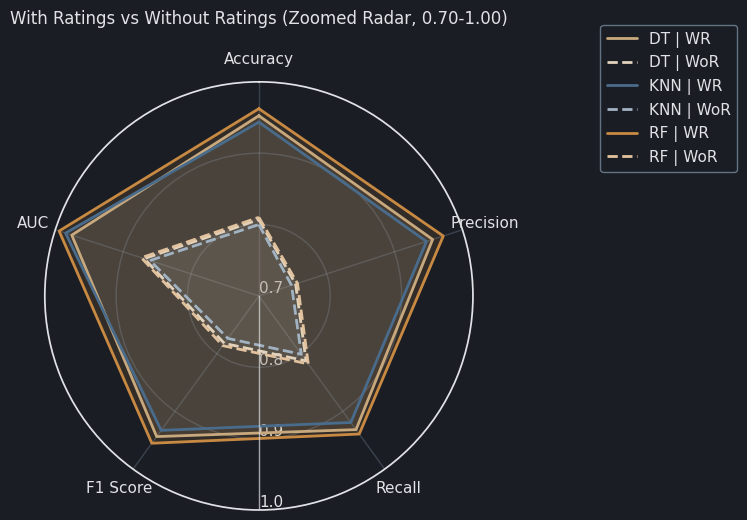

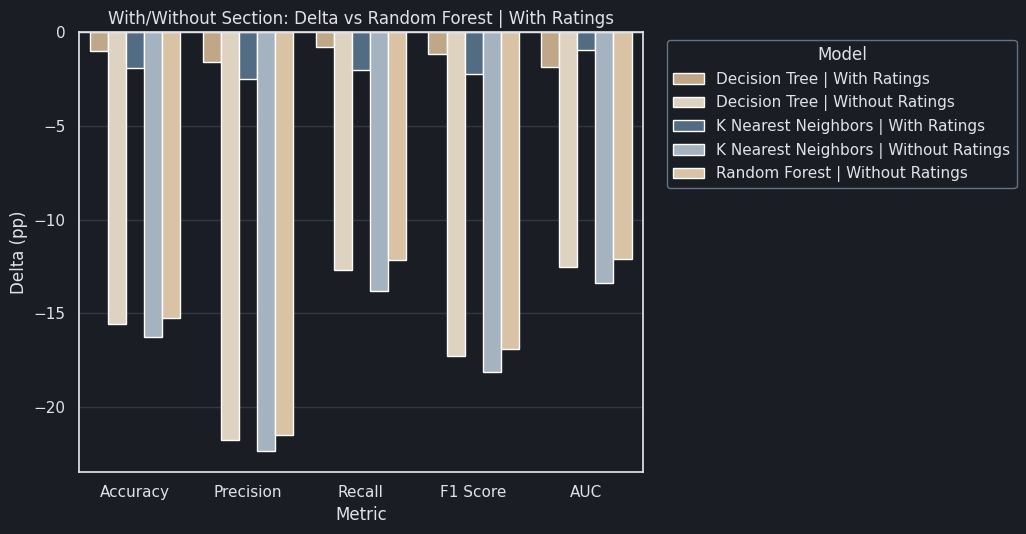

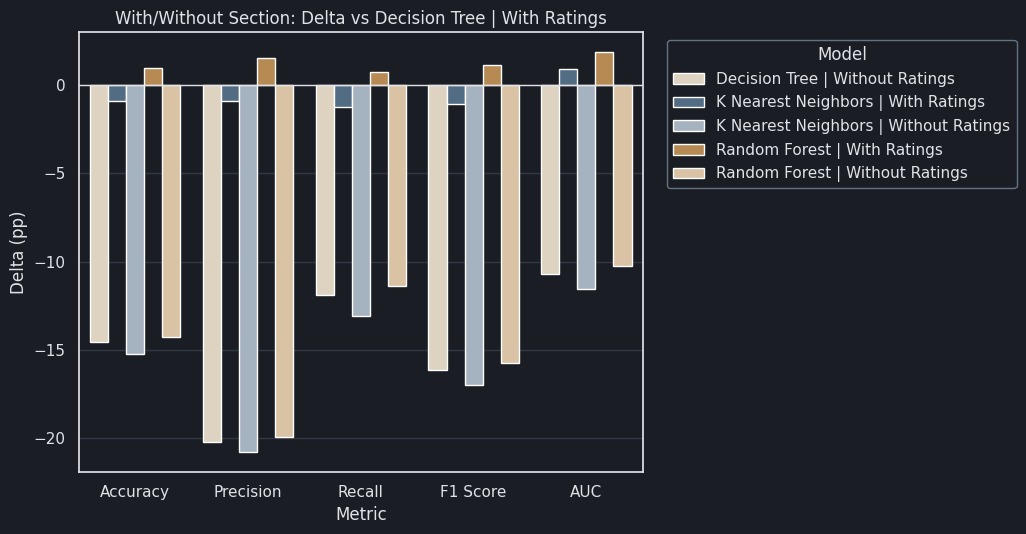

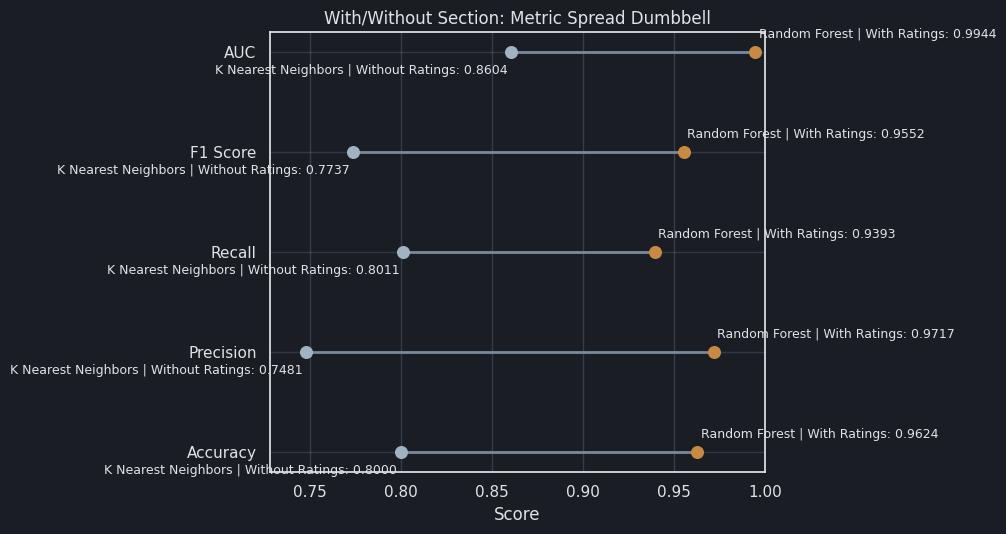

In [71]:
# Additional with-vs-without plots: zoomed radar, deltas vs reference models, and a dumbbell chart.
# Rebuild helper artifacts only if the previous comparison cell has not been executed.
if (
    'with_without_flat' not in globals()
    or 'with_without_trace_palette' not in globals()
    or 'with_without_trace_styles' not in globals()
    or 'with_without_fill_alpha' not in globals()
):
    with_without_tmp = with_without_long.pivot_table(
        index=['Model', 'Feature Set'],
        columns='Metric',
        values='Score',
        aggfunc='mean'
    ).reindex(columns=RADAR_METRICS)
    with_without_extra_pivot = with_without_tmp.copy()
    with_without_extra_pivot.index = [f"{m} | {fs}" for m, fs in with_without_extra_pivot.index]

    with_without_extra_palette = {}
    with_without_extra_styles = {}
    with_without_extra_fill_alpha = {}
    for model, feature_set in with_without_tmp.index:
        label = f"{model} | {feature_set}"
        base = MODEL_PALETTE.get(model, BASE_PALETTE[2])
        is_without = feature_set == 'Without Ratings'
        with_without_extra_palette[label] = _blend_with_white(base, 0.48) if is_without else base
        with_without_extra_styles[label] = '--' if is_without else '-'
        with_without_extra_fill_alpha[label] = 0.06 if is_without else 0.14
else:
    with_without_extra_pivot = with_without_flat.copy()
    with_without_extra_palette = with_without_trace_palette.copy()
    with_without_extra_styles = with_without_trace_styles.copy()
    with_without_extra_fill_alpha = with_without_fill_alpha.copy()

# Compact legend labels for the zoomed radar only.
legend_model_short = {
    'Decision Tree': 'DT',
    'K Nearest Neighbors': 'KNN',
    'Random Forest': 'RF',
    'Logistic Regression': 'LR'
}
legend_feature_short = {'With Ratings': 'WR', 'Without Ratings': 'WoR'}

def _short_with_without_label(label):
    parts = [p.strip() for p in str(label).split('|')]
    if len(parts) == 2:
        model, feature_set = parts
        return f"{legend_model_short.get(model, model)} | {legend_feature_short.get(feature_set, feature_set)}"
    return str(label)

with_without_zoom_pivot = with_without_extra_pivot.copy()
with_without_zoom_pivot.index = [_short_with_without_label(idx) for idx in with_without_extra_pivot.index]

with_without_zoom_palette = {}
with_without_zoom_styles = {}
with_without_zoom_fill_alpha = {}
for label in with_without_extra_pivot.index:
    short_label = _short_with_without_label(label)
    with_without_zoom_palette[short_label] = with_without_extra_palette[label]
    with_without_zoom_styles[short_label] = with_without_extra_styles[label]
    with_without_zoom_fill_alpha[short_label] = with_without_extra_fill_alpha[label]

plot_zoomed_radar_from_pivot(
    with_without_zoom_pivot,
    'With Ratings vs Without Ratings (Zoomed Radar, 0.70-1.00)',
    rmin=0.70,
    rmax=1.00,
    palette=with_without_zoom_palette,
    line_styles=with_without_zoom_styles,
    fill_alpha_map=with_without_zoom_fill_alpha,
)

rf_reference = 'Random Forest | With Ratings' if 'Random Forest | With Ratings' in with_without_extra_pivot.index else None
if rf_reference is None:
    rf_candidates = [i for i in with_without_extra_pivot.index if str(i).startswith('Random Forest')]
    if len(rf_candidates) > 0:
        rf_reference = rf_candidates[0]

if rf_reference is not None:
    plot_delta_vs_reference(
        with_without_extra_pivot,
        reference_label=rf_reference,
        title=f'With/Without Section: Delta vs {rf_reference}',
        palette=with_without_extra_palette,
    )

dt_reference = 'Decision Tree | With Ratings' if 'Decision Tree | With Ratings' in with_without_extra_pivot.index else None
if dt_reference is None:
    dt_candidates = [i for i in with_without_extra_pivot.index if str(i).startswith('Decision Tree')]
    if len(dt_candidates) > 0:
        dt_reference = dt_candidates[0]

if dt_reference is not None:
    plot_delta_vs_reference(
        with_without_extra_pivot,
        reference_label=dt_reference,
        title=f'With/Without Section: Delta vs {dt_reference}',
        palette=with_without_extra_palette,
    )

plot_metric_dumbbell(
    with_without_extra_pivot,
    title='With/Without Section: Metric Spread Dumbbell',
    palette=with_without_extra_palette,
)


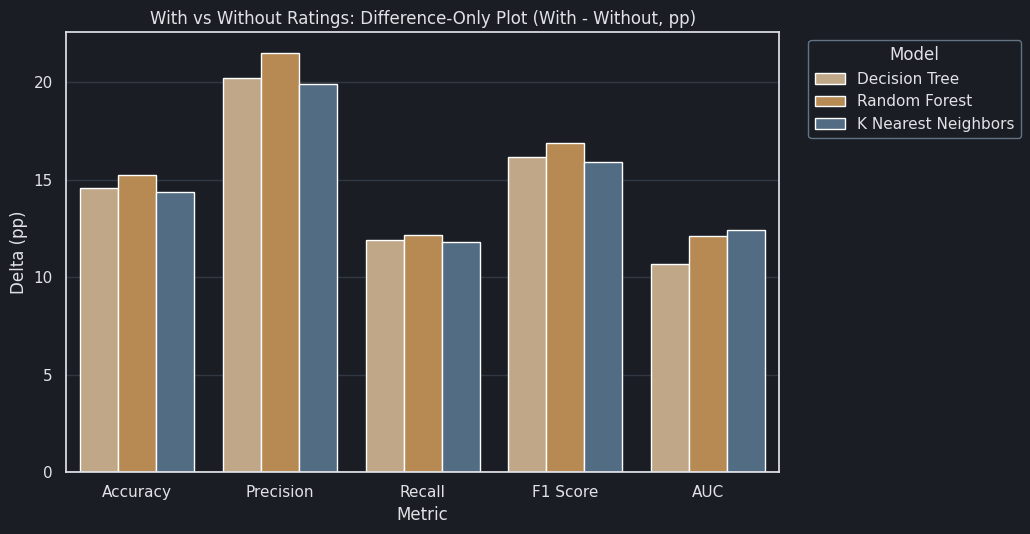

In [72]:
# Plot metric deltas for with-vs-without ratings (With - Without) by model.
model_order = ['Decision Tree', 'Random Forest', 'K Nearest Neighbors']

diff_rows = []
for model in model_order:
    if (model, 'With Ratings') not in with_without_pivot.index:
        continue
    if (model, 'Without Ratings') not in with_without_pivot.index:
        continue

    with_vals = with_without_pivot.loc[(model, 'With Ratings')]
    without_vals = with_without_pivot.loc[(model, 'Without Ratings')]
    deltas = with_vals - without_vals

    for metric in RADAR_METRICS:
        diff_rows.append({
            'Model': model,
            'Metric': metric,
            'Delta': deltas[metric],
            'Delta_pp': deltas[metric] * 100
        })

diff_only_df = pd.DataFrame(diff_rows)

plt.figure(figsize=(10.5, 5.5))
ax = sns.barplot(
    data=diff_only_df,
    x='Metric',
    y='Delta_pp',
    hue='Model',
    order=RADAR_METRICS,
    hue_order=model_order,
    palette={m: MODEL_PALETTE[m] for m in model_order}
)
ax.axhline(0, color=PLOT_FG, linewidth=1)
plt.title('With vs Without Ratings: Difference-Only Plot (With - Without, pp)')
plt.ylabel('Delta (pp)')
plt.xlabel('Metric')
legend = plt.legend(title='Model', bbox_to_anchor=(1.03, 1), loc='upper left')
style_legend(legend)
style_axes(ax)
plt.tight_layout()
plt.show()


## **Conclusions**

---


This project addressed a practical business question: **which factors drive rail customer satisfaction, and how can we use that insight to reduce dissatisfaction and improve retention**.

**Context and data used**
- We analyzed `119,567` customer trip records with operational, profile, and service-quality variables.
- The target variable is `Satisfied` (`Y`/`N`), with a slight imbalance (`56.6%` not satisfied, `43.4%` satisfied).
- A key business constraint is that service ratings are requested by **post-service email** and customers are not required to respond, so rating-based data is informative but not always available.

**How the conclusions were reached**
- We first used EDA and segment analysis to identify where dissatisfaction concentrates.
- We measured feature-target relationships using categorical association analysis (Cramer's V) and correlation for true numerical variables.
- We then built and compared classification models (Logistic Regression, KNN, Decision Tree, Random Forest), tuned shortlisted models with stratified cross-validation (`RandomizedSearchCV`), and validated results on a held-out test set.
- To reflect real operations, we repeated the workflow with a second pipeline that excludes ratings (the no-rating feature set).

**Most relevant findings**
- Satisfaction is mainly explained by **service-experience quality** (boarding, WiFi, entertainment, comfort, cleanliness, onboard service) rather than by numeric travel context alone.
- Strongest drivers include `Boarding Rating` (`0.628`), `Ticket Class` (`0.509`), `Onboard WiFi Rating` (`0.484`), `Work or Leisure` (`0.463`), and `Onboard Entertainment Rating` (`0.463`).
- Segment evidence is clear: for example, `Onboard WiFi Rating = 5` is associated with very high satisfaction (`~98.96%`), while leisure travelers are much less likely to be satisfied (`~8.38%`).
- With ratings available, tuned **Random Forest** is the best model (`Accuracy 0.9651`, `F1 0.9584`, `AUC 0.9948`).
- Without ratings, tuned **Random Forest** remains the best practical option (`Accuracy 0.8086`, `F1 0.7835`, `AUC 0.8742`), but with expected performance loss versus the rating-enabled model.

**Why this matters for business decisions**
- If the company relies only on rating-dependent models, it loses coverage whenever customers do not submit post-trip surveys.
- Therefore, one model is not enough for reliable operations. The evidence supports a **two-track deployment**:
1. `Rating service model (with ratings)` for post-trip recovery prioritization, root-cause diagnosis, and high-precision campaign targeting.
2. `No Rating service model (without ratings)` for broader proactive targeting when feedback is missing.

**Limitations to acknowledge**
- Rating availability depends on customer willingness to answer email surveys, which can introduce both data coverage gaps and response bias.
- Some numeric effects (for example delays) are weaker than experience ratings, so operational-only predictions naturally have lower ceiling performance.
- Performance should be monitored over time for drift and shifting customer behavior.

**Recommended next steps**
1. Operationalize both model tracks and route each case by rating availability.
2. Prioritize improvement actions on highest-impact drivers: boarding flow, WiFi stability, comfort/cleanliness consistency, and segment-specific gaps (especially leisure/economy).
3. Run A/B tests on model-driven interventions to measure uplift in retention and satisfaction.
4. Add ongoing monitoring for survey response rate, model calibration, and metric drift by segment.


---
